In [ ]:
import pandas as pd
import numpy as np
import csv
import torch.optim as optim
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random




# Data Loading

In [ ]:
df = pd.read_csv("One-Hot_Encoded_Tags_with_Metadata.csv")

In [ ]:
df.head()

,imdb_id,title,plot_synopsis,split,absurd,action,adult comedy,allegory,alternate history,alternate reality,...,sentimental,storytelling,stupid,suicidal,suspenseful,thought-provoking,tragedy,violence,western,whimsical
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",train,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",test,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...",train,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (A...",val,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
df.columns

Index(['imdb_id', 'title', 'plot_synopsis', 'split', 'absurd', 'action',
       'adult comedy', 'allegory', 'alternate history', 'alternate reality',
       'anti war', 'atmospheric', 'autobiographical', 'avant garde',
       'blaxploitation', 'bleak', 'boring', 'brainwashing', 'christian film',
       'claustrophobic', 'clever', 'comedy', 'comic', 'cruelty', 'cult',
       'cute', 'dark', 'depressing', 'dramatic', 'entertaining', 'fantasy',
       'feel-good', 'flashback', 'good versus evil', 'gothic',
       'grindhouse film', 'haunting', 'historical', 'historical fiction',
       'home movie', 'horror', 'humor', 'insanity', 'inspiring', 'intrigue',
       'magical realism', 'melodrama', 'murder', 'mystery', 'neo noir',
       'non fiction', 'paranormal', 'philosophical', 'plot twist',
       'pornographic', 'prank', 'psychedelic', 'psychological', 'queer',
       'realism', 'revenge', 'romantic', 'sadist', 'satire', 'sci-fi',
       'sentimental', 'storytelling', 'stupid', 'suicidal

In [ ]:
split_counts = df['split'].value_counts()
print(split_counts)

split
train    9489
test     2966
val      2373
Name: count, dtype: int64


In [ ]:
total = 9489 + 2966 + 2373
print("dataset size: ", total)

train_split = 9489 / (9489 + 2373)
print("train/val split: ", train_split)

test_split = 2966/ total
print("test split: ", test_split)

#80% of dataset used for training/validation, 20% for testing
#training data is split 80/20 into train/val

dataset size:  14828
train/val split:  0.7999494183105715
test split:  0.20002697599136768


# Data processing
Create train, val, test datasets
Convert the synopsis text data into numberic embeddings

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

Split dataset

In [ ]:
texts = df['plot_synopsis'].tolist() #inputs: movie synopsis
labels = df.iloc[:, 4:].values  # outputs genre labels

# Dataset split: train 0.7, val 0.15, test 0.15
labels_tensor = torch.tensor(labels, dtype=torch.float32)
train_texts, temp_texts, train_labels, temp_labels = train_test_split(texts, labels_tensor, test_size=0.3, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, random_state=42)




Create embeddings / feature vectors using sklearn TfidfVectorizer:

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [ ]:
# Convert movie synopsis to TF-IDF feature vectors
vectorizer = TfidfVectorizer(max_features=2000)
train_features = vectorizer.fit_transform(train_texts).toarray()
val_features = vectorizer.transform(val_texts).toarray()
test_features = vectorizer.transform(test_texts).toarray()

# Convert to tensors
train_features_tensor = torch.tensor(train_features, dtype=torch.float32)
val_features_tensor = torch.tensor(val_features, dtype=torch.float32)
test_features_tensor = torch.tensor(test_features, dtype=torch.float32)

Create data loaders

In [ ]:
class IMDBDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Create datasets
train_dataset = IMDBDataset(train_features_tensor, train_labels)
val_dataset = IMDBDataset(val_features_tensor, val_labels)
test_dataset = IMDBDataset(test_features_tensor, test_labels)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)


# Model

In [ ]:
# Check if CUDA is available
print(torch.cuda.is_available())  # Should print True if GPU is available


True


In [ ]:
class Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [ ]:
input_dim = 2000  # TF-IDF feature size
hidden_dim = 5000
output_dim = labels.shape[1]  # Number of genres

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Initialize model, loss function, optimizer
model = Classifier(input_dim, hidden_dim, output_dim).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
output_dim

71

In [ ]:
!pip install torchviz


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
#this is the updated model:
class ClassifierD3(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ClassifierD3, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = ClassifierD3(2000, 5000, 71).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [ ]:
import torch
from torchviz import make_dot

x = torch.randn(1, input_dim).to(device)
y = model(x)

make_dot(y, params=dict(model.named_parameters())).render('model_diagram', format='png')


'model_diagram.png'

# Regular training & Hyperparameter Tuning

This training loop trains the model but does not track forgetting events

It is used for hyperparameter tuning

In [ ]:
# Training loop
def regular_train(model, num_epochs,learning_rate):

  train_losses = []
  train_accuracies = []
  criterion = nn.BCEWithLogitsLoss()
  optimizer = optim.Adam(model.parameters(), lr = learning_rate)

  for epoch in range(num_epochs):
      model.train()
      total_loss = 0
      correct_preds = 0
      total_samples = 0

      for features, labels in train_loader:
          features, labels = features.to(device), labels.to(device)  # No GPU

          optimizer.zero_grad()
          outputs = model(features)

          # Calculate loss
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          total_loss += loss.item()

          # Genre predicted if output > 0.5
          predicted = torch.sigmoid(outputs) > 0.5

          # Count how many genres are correctly predicted for each sample
          correct_preds_batch = (predicted == labels).sum(dim=1)  # For each sample in the batch

          # Check if all genres are correctly classified
          # Accuracy threshold can be relaxed to below 100% (change * 1 to * 0.95)
          correct_preds += (correct_preds_batch >= (labels.size(1) * 1)).sum().item()

          total_samples += labels.size(0)  # Total number of samples in batch (not total genres)

      avg_loss = total_loss / len(train_loader)
      accuracy = correct_preds / total_samples * 100

      # Append the metrics to lists
      train_losses.append(avg_loss)
      train_accuracies.append(accuracy)

      print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

  print("Training finished\nn")


**Note that there is an error: the accuracy printed as 75% test accuracy prediction is actually 50% test accuracy**

In [ ]:
def test_accuracy(model):
  model.eval()

  # Test accuracy for 100% of labels correctly predicted
  total_test_loss = 0
  correct_test_preds = 0
  total_test_samples = 0

  with torch.no_grad():
      for features, labels in test_loader:
          features, labels = features.to(device), labels.to(device)

          outputs = model(features)

          predicted = torch.sigmoid(outputs) > 0.5

          correct_preds_batch = (predicted == labels).sum(dim=1)

          #test accuracy can be relaxed for mult-label classification to 0.95% of labels accruately predicted
          correct_test_preds += (correct_preds_batch >= (labels.size(1) * 1)).sum().item()

          total_test_samples += labels.size(0)

  test_accuracy = correct_test_preds / total_test_samples * 100
  print(f"100% Test Accuracy: {test_accuracy:.2f}%")

  # Test accuracy for 95% of labels correctly predicted
  total_test_loss = 0
  correct_test_preds = 0
  total_test_samples = 0

  with torch.no_grad():
      for features, labels in test_loader:
          features, labels = features.to(device), labels.to(device)

          outputs = model(features)

          predicted = torch.sigmoid(outputs) > 0.5

          correct_preds_batch = (predicted == labels).sum(dim=1)

          #test accuracy can be relaxed for mult-label classification to 0.95% of labels accruately predicted
          correct_test_preds += (correct_preds_batch >= (labels.size(1) * 0.95)).sum().item()

          total_test_samples += labels.size(0)

  test_accuracy = correct_test_preds / total_test_samples * 100
  print(f"95% Test Accuracy: {test_accuracy:.2f}%")

  # Test accuracy for 90% of labels correctly predicted
  total_test_loss = 0
  correct_test_preds = 0
  total_test_samples = 0

  with torch.no_grad():
      for features, labels in test_loader:
          features, labels = features.to(device), labels.to(device)

          outputs = model(features)

          predicted = torch.sigmoid(outputs) > 0.5

          correct_preds_batch = (predicted == labels).sum(dim=1)

          #test accuracy can be relaxed for mult-label classification to 0.95% of labels accruately predicted
          correct_test_preds += (correct_preds_batch >= (labels.size(1) * 0.9)).sum().item()

          total_test_samples += labels.size(0)

  test_accuracy = correct_test_preds / total_test_samples * 100
  print(f"90% Test Accuracy: {test_accuracy:.2f}%")

  # Test accuracy for 75% of labels correctly predicted
  total_test_loss = 0
  correct_test_preds = 0
  total_test_samples = 0

  with torch.no_grad():
      for features, labels in test_loader:
          features, labels = features.to(device), labels.to(device)

          outputs = model(features)

          predicted = torch.sigmoid(outputs) > 0.5

          correct_preds_batch = (predicted == labels).sum(dim=1)

          #test accuracy can be relaxed for mult-label classification to 0.95% of labels accruately predicted
          correct_test_preds += (correct_preds_batch >= (labels.size(1) * 0.5)).sum().item()

          total_test_samples += labels.size(0)

  test_accuracy = correct_test_preds / total_test_samples * 100
  print(f"75% Test Accuracy: {test_accuracy:.2f}%")


In [ ]:
model = Classifier(2000, 5000, 71).to(device)
regular_train(model, 30,0.01)
test_accuracy(model)

Epoch 1/30, Loss: 0.1371, Accuracy: 5.13%
Epoch 2/30, Loss: 0.1163, Accuracy: 8.66%
Epoch 3/30, Loss: 0.1007, Accuracy: 12.20%
Epoch 4/30, Loss: 0.0842, Accuracy: 17.09%
Epoch 5/30, Loss: 0.0699, Accuracy: 24.04%
Epoch 6/30, Loss: 0.0587, Accuracy: 31.23%
Epoch 7/30, Loss: 0.0495, Accuracy: 36.92%
Epoch 8/30, Loss: 0.0435, Accuracy: 42.47%
Epoch 9/30, Loss: 0.0391, Accuracy: 46.33%
Epoch 10/30, Loss: 0.0355, Accuracy: 49.76%
Epoch 11/30, Loss: 0.0331, Accuracy: 52.80%
Epoch 12/30, Loss: 0.0311, Accuracy: 55.28%
Epoch 13/30, Loss: 0.0293, Accuracy: 57.54%
Epoch 14/30, Loss: 0.0282, Accuracy: 58.88%
Epoch 15/30, Loss: 0.0272, Accuracy: 60.97%
Epoch 16/30, Loss: 0.0264, Accuracy: 61.88%
Epoch 17/30, Loss: 0.0255, Accuracy: 63.30%
Epoch 18/30, Loss: 0.0245, Accuracy: 64.95%
Epoch 19/30, Loss: 0.0240, Accuracy: 65.43%
Epoch 20/30, Loss: 0.0240, Accuracy: 65.85%
Epoch 21/30, Loss: 0.0229, Accuracy: 67.10%
Epoch 22/30, Loss: 0.0227, Accuracy: 68.14%
Epoch 23/30, Loss: 0.0220, Accuracy: 67.50%

Tuning hidden layer width

In [ ]:
model = Classifier(2000, 10000, 71).to(device)
regular_train(model, 30,0.01)
test_accuracy(model)

Epoch 1/30, Loss: 0.1358, Accuracy: 5.31%
Epoch 2/30, Loss: 0.1155, Accuracy: 9.25%
Epoch 3/30, Loss: 0.0990, Accuracy: 12.69%
Epoch 4/30, Loss: 0.0813, Accuracy: 19.21%
Epoch 5/30, Loss: 0.0665, Accuracy: 26.47%
Epoch 6/30, Loss: 0.0546, Accuracy: 33.35%
Epoch 7/30, Loss: 0.0468, Accuracy: 39.57%
Epoch 8/30, Loss: 0.0413, Accuracy: 45.24%
Epoch 9/30, Loss: 0.0368, Accuracy: 49.17%
Epoch 10/30, Loss: 0.0344, Accuracy: 52.23%
Epoch 11/30, Loss: 0.0320, Accuracy: 56.00%
Epoch 12/30, Loss: 0.0303, Accuracy: 57.02%
Epoch 13/30, Loss: 0.0284, Accuracy: 59.70%
Epoch 14/30, Loss: 0.0276, Accuracy: 61.21%
Epoch 15/30, Loss: 0.0267, Accuracy: 62.56%
Epoch 16/30, Loss: 0.0257, Accuracy: 63.40%
Epoch 17/30, Loss: 0.0252, Accuracy: 64.88%
Epoch 18/30, Loss: 0.0245, Accuracy: 65.23%
Epoch 19/30, Loss: 0.0243, Accuracy: 66.40%
Epoch 20/30, Loss: 0.0236, Accuracy: 67.14%
Epoch 21/30, Loss: 0.0232, Accuracy: 67.46%
Epoch 22/30, Loss: 0.0221, Accuracy: 70.13%
Epoch 23/30, Loss: 0.0227, Accuracy: 70.02%

## Learning rate (0.05, 0.1, 0.03, 0.005, 0.0025, 0.001)

In [ ]:
model = Classifier(2000, 5000, 71).to(device)
regular_train(model, 30,0.05)
test_accuracy(model)

Epoch 1/30, Loss: 0.1523, Accuracy: 3.88%
Epoch 2/30, Loss: 0.1308, Accuracy: 6.11%
Epoch 3/30, Loss: 0.1245, Accuracy: 6.99%
Epoch 4/30, Loss: 0.1224, Accuracy: 7.56%
Epoch 5/30, Loss: 0.1203, Accuracy: 8.50%
Epoch 6/30, Loss: 0.1194, Accuracy: 9.14%
Epoch 7/30, Loss: 0.1182, Accuracy: 9.34%
Epoch 8/30, Loss: 0.1170, Accuracy: 9.76%
Epoch 9/30, Loss: 0.1164, Accuracy: 10.30%
Epoch 10/30, Loss: 0.1169, Accuracy: 10.36%
Epoch 11/30, Loss: 0.1160, Accuracy: 10.67%
Epoch 12/30, Loss: 0.1156, Accuracy: 10.62%
Epoch 13/30, Loss: 0.1154, Accuracy: 10.66%
Epoch 14/30, Loss: 0.1148, Accuracy: 10.91%
Epoch 15/30, Loss: 0.1140, Accuracy: 11.07%
Epoch 16/30, Loss: 0.1136, Accuracy: 11.64%
Epoch 17/30, Loss: 0.1136, Accuracy: 11.80%
Epoch 18/30, Loss: 0.1135, Accuracy: 11.57%
Epoch 19/30, Loss: 0.1130, Accuracy: 11.96%
Epoch 20/30, Loss: 0.1130, Accuracy: 12.45%
Epoch 21/30, Loss: 0.1132, Accuracy: 11.78%
Epoch 22/30, Loss: 0.1127, Accuracy: 12.82%
Epoch 23/30, Loss: 0.1124, Accuracy: 12.34%
Epoch

In [ ]:
model = Classifier(2000, 5000, 71).to(device)
regular_train(model, 30,0.1)
test_accuracy(model)

Epoch 1/30, Loss: 0.1757, Accuracy: 2.27%
Epoch 2/30, Loss: 0.1363, Accuracy: 3.43%
Epoch 3/30, Loss: 0.1348, Accuracy: 3.55%
Epoch 4/30, Loss: 0.1350, Accuracy: 3.56%
Epoch 5/30, Loss: 0.1344, Accuracy: 3.97%
Epoch 6/30, Loss: 0.1336, Accuracy: 3.87%
Epoch 7/30, Loss: 0.1336, Accuracy: 3.58%
Epoch 8/30, Loss: 0.1337, Accuracy: 3.83%
Epoch 9/30, Loss: 0.1336, Accuracy: 4.02%
Epoch 10/30, Loss: 0.1336, Accuracy: 3.83%
Epoch 11/30, Loss: 0.1335, Accuracy: 3.88%
Epoch 12/30, Loss: 0.1337, Accuracy: 3.59%
Epoch 13/30, Loss: 0.1335, Accuracy: 3.96%
Epoch 14/30, Loss: 0.1339, Accuracy: 3.84%
Epoch 15/30, Loss: 0.1338, Accuracy: 3.96%
Epoch 16/30, Loss: 0.1339, Accuracy: 3.80%
Epoch 17/30, Loss: 0.1345, Accuracy: 3.40%
Epoch 18/30, Loss: 0.1339, Accuracy: 3.90%
Epoch 19/30, Loss: 0.1347, Accuracy: 3.72%
Epoch 20/30, Loss: 0.1344, Accuracy: 4.10%
Epoch 21/30, Loss: 0.1344, Accuracy: 3.70%
Epoch 22/30, Loss: 0.1345, Accuracy: 3.69%
Epoch 23/30, Loss: 0.1352, Accuracy: 3.47%
Epoch 24/30, Loss: 0

In [ ]:
model = Classifier(2000, 5000, 71).to(device)
regular_train(model, 30,0.03)
test_accuracy(model)

Epoch 1/30, Loss: 0.1443, Accuracy: 4.52%
Epoch 2/30, Loss: 0.1262, Accuracy: 6.97%
Epoch 3/30, Loss: 0.1182, Accuracy: 8.41%
Epoch 4/30, Loss: 0.1118, Accuracy: 9.44%
Epoch 5/30, Loss: 0.1071, Accuracy: 11.10%
Epoch 6/30, Loss: 0.1033, Accuracy: 12.18%
Epoch 7/30, Loss: 0.1003, Accuracy: 13.65%
Epoch 8/30, Loss: 0.0985, Accuracy: 13.74%
Epoch 9/30, Loss: 0.0963, Accuracy: 15.05%
Epoch 10/30, Loss: 0.0949, Accuracy: 16.05%
Epoch 11/30, Loss: 0.0929, Accuracy: 16.41%
Epoch 12/30, Loss: 0.0928, Accuracy: 17.01%
Epoch 13/30, Loss: 0.0910, Accuracy: 17.88%
Epoch 14/30, Loss: 0.0899, Accuracy: 18.72%
Epoch 15/30, Loss: 0.0883, Accuracy: 19.11%
Epoch 16/30, Loss: 0.0873, Accuracy: 19.75%
Epoch 17/30, Loss: 0.0876, Accuracy: 19.94%
Epoch 18/30, Loss: 0.0877, Accuracy: 19.86%
Epoch 19/30, Loss: 0.0867, Accuracy: 20.76%
Epoch 20/30, Loss: 0.0863, Accuracy: 20.99%
Epoch 21/30, Loss: 0.0852, Accuracy: 20.41%
Epoch 22/30, Loss: 0.0847, Accuracy: 21.48%
Epoch 23/30, Loss: 0.0836, Accuracy: 22.29%
E

In [ ]:
model = Classifier(2000, 5000, 71).to(device)
regular_train(model, 30,0.005)
test_accuracy(model)

Epoch 1/30, Loss: 0.1391, Accuracy: 4.64%
Epoch 2/30, Loss: 0.1152, Accuracy: 8.93%
Epoch 3/30, Loss: 0.0983, Accuracy: 12.91%
Epoch 4/30, Loss: 0.0781, Accuracy: 20.18%
Epoch 5/30, Loss: 0.0589, Accuracy: 30.74%
Epoch 6/30, Loss: 0.0448, Accuracy: 41.70%
Epoch 7/30, Loss: 0.0361, Accuracy: 48.28%
Epoch 8/30, Loss: 0.0303, Accuracy: 54.18%
Epoch 9/30, Loss: 0.0261, Accuracy: 59.72%
Epoch 10/30, Loss: 0.0226, Accuracy: 65.90%
Epoch 11/30, Loss: 0.0205, Accuracy: 69.24%
Epoch 12/30, Loss: 0.0186, Accuracy: 72.87%
Epoch 13/30, Loss: 0.0178, Accuracy: 74.67%
Epoch 14/30, Loss: 0.0170, Accuracy: 76.55%
Epoch 15/30, Loss: 0.0164, Accuracy: 77.68%
Epoch 16/30, Loss: 0.0159, Accuracy: 79.13%
Epoch 17/30, Loss: 0.0157, Accuracy: 79.53%
Epoch 18/30, Loss: 0.0155, Accuracy: 80.26%
Epoch 19/30, Loss: 0.0153, Accuracy: 81.00%
Epoch 20/30, Loss: 0.0152, Accuracy: 81.18%
Epoch 21/30, Loss: 0.0148, Accuracy: 81.75%
Epoch 22/30, Loss: 0.0146, Accuracy: 82.47%
Epoch 23/30, Loss: 0.0153, Accuracy: 81.83%

In [ ]:
model = Classifier(2000, 5000, 71).to(device)
regular_train(model, 30,0.0025)
test_accuracy(model)

Epoch 1/30, Loss: 0.1413, Accuracy: 4.25%
Epoch 2/30, Loss: 0.1165, Accuracy: 8.75%
Epoch 3/30, Loss: 0.1022, Accuracy: 11.48%
Epoch 4/30, Loss: 0.0855, Accuracy: 16.10%
Epoch 5/30, Loss: 0.0679, Accuracy: 23.81%
Epoch 6/30, Loss: 0.0511, Accuracy: 35.61%
Epoch 7/30, Loss: 0.0387, Accuracy: 48.69%
Epoch 8/30, Loss: 0.0302, Accuracy: 58.53%
Epoch 9/30, Loss: 0.0259, Accuracy: 63.15%
Epoch 10/30, Loss: 0.0239, Accuracy: 64.30%
Epoch 11/30, Loss: 0.0213, Accuracy: 69.00%
Epoch 12/30, Loss: 0.0177, Accuracy: 74.87%
Epoch 13/30, Loss: 0.0156, Accuracy: 80.12%
Epoch 14/30, Loss: 0.0146, Accuracy: 82.64%
Epoch 15/30, Loss: 0.0141, Accuracy: 83.34%
Epoch 16/30, Loss: 0.0139, Accuracy: 83.99%
Epoch 17/30, Loss: 0.0133, Accuracy: 85.00%
Epoch 18/30, Loss: 0.0127, Accuracy: 86.05%
Epoch 19/30, Loss: 0.0127, Accuracy: 86.77%
Epoch 20/30, Loss: 0.0124, Accuracy: 87.06%
Epoch 21/30, Loss: 0.0127, Accuracy: 87.39%
Epoch 22/30, Loss: 0.0127, Accuracy: 87.23%
Epoch 23/30, Loss: 0.0125, Accuracy: 87.91%

In [ ]:
model = Classifier(2000, 5000, 71).to(device)
regular_train(model, 30,0.001)
test_accuracy(model)

Epoch 1/30, Loss: 0.1479, Accuracy: 2.71%
Epoch 2/30, Loss: 0.1198, Accuracy: 7.54%
Epoch 3/30, Loss: 0.1096, Accuracy: 9.61%
Epoch 4/30, Loss: 0.1003, Accuracy: 11.72%
Epoch 5/30, Loss: 0.0909, Accuracy: 14.07%
Epoch 6/30, Loss: 0.0811, Accuracy: 16.46%
Epoch 7/30, Loss: 0.0714, Accuracy: 20.44%
Epoch 8/30, Loss: 0.0622, Accuracy: 25.45%
Epoch 9/30, Loss: 0.0537, Accuracy: 31.30%
Epoch 10/30, Loss: 0.0457, Accuracy: 39.28%
Epoch 11/30, Loss: 0.0391, Accuracy: 47.20%
Epoch 12/30, Loss: 0.0333, Accuracy: 55.70%
Epoch 13/30, Loss: 0.0284, Accuracy: 63.56%
Epoch 14/30, Loss: 0.0245, Accuracy: 70.75%
Epoch 15/30, Loss: 0.0213, Accuracy: 75.70%
Epoch 16/30, Loss: 0.0189, Accuracy: 79.81%
Epoch 17/30, Loss: 0.0170, Accuracy: 82.62%
Epoch 18/30, Loss: 0.0158, Accuracy: 83.69%
Epoch 19/30, Loss: 0.0151, Accuracy: 84.56%
Epoch 20/30, Loss: 0.0147, Accuracy: 83.88%
Epoch 21/30, Loss: 0.0141, Accuracy: 84.36%
Epoch 22/30, Loss: 0.0137, Accuracy: 85.07%
Epoch 23/30, Loss: 0.0130, Accuracy: 86.20%


## Dropout rate (0.1, 0.3, 0.4, 0.5)

Training the model on 3 different drop out rates, the previouse code used a drop out rate of 0.3.

The learning rate is set to 0.05 as it had the optimal test accuracy in the previous section.

In [ ]:
class ClassifierD1(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ClassifierD1, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [ ]:
model = ClassifierD1(2000, 5000, 71).to(device)
regular_train(model, 30,0.005)
test_accuracy(model)

Epoch 1/30, Loss: 0.1394, Accuracy: 4.77%
Epoch 2/30, Loss: 0.1144, Accuracy: 9.10%
Epoch 3/30, Loss: 0.0948, Accuracy: 13.71%
Epoch 4/30, Loss: 0.0706, Accuracy: 23.87%
Epoch 5/30, Loss: 0.0487, Accuracy: 40.15%
Epoch 6/30, Loss: 0.0360, Accuracy: 50.78%
Epoch 7/30, Loss: 0.0316, Accuracy: 52.26%
Epoch 8/30, Loss: 0.0258, Accuracy: 60.20%
Epoch 9/30, Loss: 0.0211, Accuracy: 68.48%
Epoch 10/30, Loss: 0.0180, Accuracy: 73.83%
Epoch 11/30, Loss: 0.0163, Accuracy: 77.58%
Epoch 12/30, Loss: 0.0148, Accuracy: 81.20%
Epoch 13/30, Loss: 0.0139, Accuracy: 83.86%
Epoch 14/30, Loss: 0.0133, Accuracy: 84.35%
Epoch 15/30, Loss: 0.0134, Accuracy: 85.16%
Epoch 16/30, Loss: 0.0130, Accuracy: 85.27%
Epoch 17/30, Loss: 0.0128, Accuracy: 85.68%
Epoch 18/30, Loss: 0.0123, Accuracy: 86.59%
Epoch 19/30, Loss: 0.0122, Accuracy: 87.71%
Epoch 20/30, Loss: 0.0119, Accuracy: 87.77%
Epoch 21/30, Loss: 0.0118, Accuracy: 88.45%
Epoch 22/30, Loss: 0.0122, Accuracy: 87.67%
Epoch 23/30, Loss: 0.0117, Accuracy: 88.23%

In [ ]:
class ClassifierD3(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ClassifierD3, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [ ]:
model = ClassifierD3(2000, 5000, 71).to(device)
regular_train(model, 30,0.005)
test_accuracy(model)

Epoch 1/30, Loss: 0.1391, Accuracy: 4.61%
Epoch 2/30, Loss: 0.1164, Accuracy: 8.62%
Epoch 3/30, Loss: 0.1011, Accuracy: 11.76%
Epoch 4/30, Loss: 0.0835, Accuracy: 17.68%
Epoch 5/30, Loss: 0.0660, Accuracy: 25.72%
Epoch 6/30, Loss: 0.0517, Accuracy: 35.63%
Epoch 7/30, Loss: 0.0416, Accuracy: 43.83%
Epoch 8/30, Loss: 0.0353, Accuracy: 49.47%
Epoch 9/30, Loss: 0.0308, Accuracy: 54.63%
Epoch 10/30, Loss: 0.0267, Accuracy: 59.76%
Epoch 11/30, Loss: 0.0243, Accuracy: 63.13%
Epoch 12/30, Loss: 0.0221, Accuracy: 66.84%
Epoch 13/30, Loss: 0.0209, Accuracy: 69.21%
Epoch 14/30, Loss: 0.0201, Accuracy: 71.41%
Epoch 15/30, Loss: 0.0195, Accuracy: 72.22%
Epoch 16/30, Loss: 0.0189, Accuracy: 73.35%
Epoch 17/30, Loss: 0.0186, Accuracy: 74.00%
Epoch 18/30, Loss: 0.0187, Accuracy: 74.37%
Epoch 19/30, Loss: 0.0181, Accuracy: 75.93%
Epoch 20/30, Loss: 0.0178, Accuracy: 76.43%
Epoch 21/30, Loss: 0.0177, Accuracy: 76.65%
Epoch 22/30, Loss: 0.0175, Accuracy: 77.65%
Epoch 23/30, Loss: 0.0171, Accuracy: 78.42%

In [ ]:
class ClassifierD5(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ClassifierD4, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [ ]:
model = ClassifierD3(2000, 5000, 71).to(device)
regular_train(model, 30,0.005)
test_accuracy(model)

Epoch 1/30, Loss: 0.1391, Accuracy: 4.67%
Epoch 2/30, Loss: 0.1154, Accuracy: 9.07%
Epoch 3/30, Loss: 0.0982, Accuracy: 12.73%
Epoch 4/30, Loss: 0.0780, Accuracy: 19.81%
Epoch 5/30, Loss: 0.0587, Accuracy: 30.54%
Epoch 6/30, Loss: 0.0440, Accuracy: 42.07%
Epoch 7/30, Loss: 0.0358, Accuracy: 49.02%
Epoch 8/30, Loss: 0.0303, Accuracy: 55.13%
Epoch 9/30, Loss: 0.0263, Accuracy: 60.39%
Epoch 10/30, Loss: 0.0224, Accuracy: 66.02%
Epoch 11/30, Loss: 0.0202, Accuracy: 70.09%
Epoch 12/30, Loss: 0.0191, Accuracy: 72.01%
Epoch 13/30, Loss: 0.0176, Accuracy: 75.15%
Epoch 14/30, Loss: 0.0168, Accuracy: 76.64%
Epoch 15/30, Loss: 0.0165, Accuracy: 77.82%
Epoch 16/30, Loss: 0.0160, Accuracy: 78.64%
Epoch 17/30, Loss: 0.0156, Accuracy: 80.08%
Epoch 18/30, Loss: 0.0157, Accuracy: 80.11%
Epoch 19/30, Loss: 0.0153, Accuracy: 81.13%
Epoch 20/30, Loss: 0.0155, Accuracy: 81.10%
Epoch 21/30, Loss: 0.0151, Accuracy: 81.45%
Epoch 22/30, Loss: 0.0151, Accuracy: 82.02%
Epoch 23/30, Loss: 0.0152, Accuracy: 82.17%

## Selected model

- input = 2000
- hiden = 5000
- learning rate = 0.005
- dropout rate = 0.4

In [ ]:
class ClassifierD3(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ClassifierD3, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [ ]:
model = ClassifierD3(2000, 5000, 71).to(device)
regular_train(model, 30,0.005)
test_accuracy(model)

# Experiment: Count forgetting events (Training while tracking forgetting events)

In [ ]:
def train_and_count_forgetting_events(epochs):

  model = ClassifierD3(2000, 5000, 71).to(device)
  criterion = nn.BCEWithLogitsLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.005)

  train_losses = []
  train_accuracies = []

  n = len(train_dataset)

  # Initialize acc and T arrays
  acc = np.zeros(n)  # # binary array, 1 = correctly classified
  T = np.zeros(n)     # count of forgetting events for each data point by index

  # Training loop
  num_epochs = epochs
  for epoch in range(num_epochs):
      model.train()
      total_loss = 0
      correct_preds = 0
      total_samples = 0

      for batch_idx, (features, labels) in enumerate(train_loader):
          features, labels = features.to(device), labels.to(device)  # Move to GPU or CPU
          batch_size = features.size(0)
          batch_start = batch_idx * batch_size
          batch_indices = np.arange(batch_start, batch_start + batch_size)

          optimizer.zero_grad()
          outputs = model(features)

          # Calculate loss
          loss = criterion(outputs, labels)
          total_loss += loss.item()

          # Predictions and forgetting count
          predicted = (torch.sigmoid(outputs) > 0.5).int()  # Multi-label classification, prediction if sigmoid(output) > 0.5
          correct = (predicted == labels).int()

          for i, idx in enumerate(batch_indices): # idx correspond to full dataset as data loader is not shuffled
              if acc[idx] == 1 and correct[i].sum().item() < labels.size(1):  # If went from correct -> incorrect
                  T[idx] += 1
              acc[idx] = int(correct[i].sum().item() == labels.size(1))  # 1 if all labels correct, else 0

          correct_preds_batch = (predicted == labels).sum(dim=1)  # For each sample in the batch

          # Check if at least 100% of genres are predicted correctly for each sample
          correct_preds += (correct_preds_batch >= (labels.size(1) * 1)).sum().item()  # Change *1 to *0.9 for at least 90% of genres predicted correctly

          total_samples += labels.size(0)  # Total number of samples in batch (not total genres)

          # Backward pass to update model
          loss.backward()
          optimizer.step()


      avg_loss = total_loss / len(train_loader)
      accuracy = correct_preds / total_samples * 100

      # Append the metrics to lists
      train_losses.append(avg_loss)
      train_accuracies.append(accuracy)

      print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

  return T, acc, train_accuracies, train_losses
  print("Forgetting counts T:", T)
  print("Final classification status acc:", acc)


In [ ]:
T, acc, train_accuracies, train_losses = train_and_count_forgetting_events(30)

Epoch 1/30, Loss: 0.1391, Accuracy: 4.69%
Epoch 2/30, Loss: 0.1162, Accuracy: 8.65%
Epoch 3/30, Loss: 0.1007, Accuracy: 12.38%
Epoch 4/30, Loss: 0.0830, Accuracy: 18.24%
Epoch 5/30, Loss: 0.0656, Accuracy: 26.13%
Epoch 6/30, Loss: 0.0511, Accuracy: 35.29%
Epoch 7/30, Loss: 0.0412, Accuracy: 43.34%
Epoch 8/30, Loss: 0.0347, Accuracy: 50.73%
Epoch 9/30, Loss: 0.0300, Accuracy: 55.20%
Epoch 10/30, Loss: 0.0264, Accuracy: 60.46%
Epoch 11/30, Loss: 0.0234, Accuracy: 64.81%
Epoch 12/30, Loss: 0.0218, Accuracy: 68.36%
Epoch 13/30, Loss: 0.0205, Accuracy: 69.82%
Epoch 14/30, Loss: 0.0202, Accuracy: 71.94%
Epoch 15/30, Loss: 0.0199, Accuracy: 72.54%
Epoch 16/30, Loss: 0.0192, Accuracy: 73.38%
Epoch 17/30, Loss: 0.0188, Accuracy: 73.89%
Epoch 18/30, Loss: 0.0180, Accuracy: 75.15%
Epoch 19/30, Loss: 0.0176, Accuracy: 75.74%
Epoch 20/30, Loss: 0.0177, Accuracy: 76.72%
Epoch 21/30, Loss: 0.0175, Accuracy: 77.22%
Epoch 22/30, Loss: 0.0172, Accuracy: 78.30%
Epoch 23/30, Loss: 0.0170, Accuracy: 78.69%

In [ ]:
test_accuracy(model)

100% Test Accuracy: 7.37%
95% Test Accuracy: 71.96%
90% Test Accuracy: 94.29%
75% Test Accuracy: 100.00%


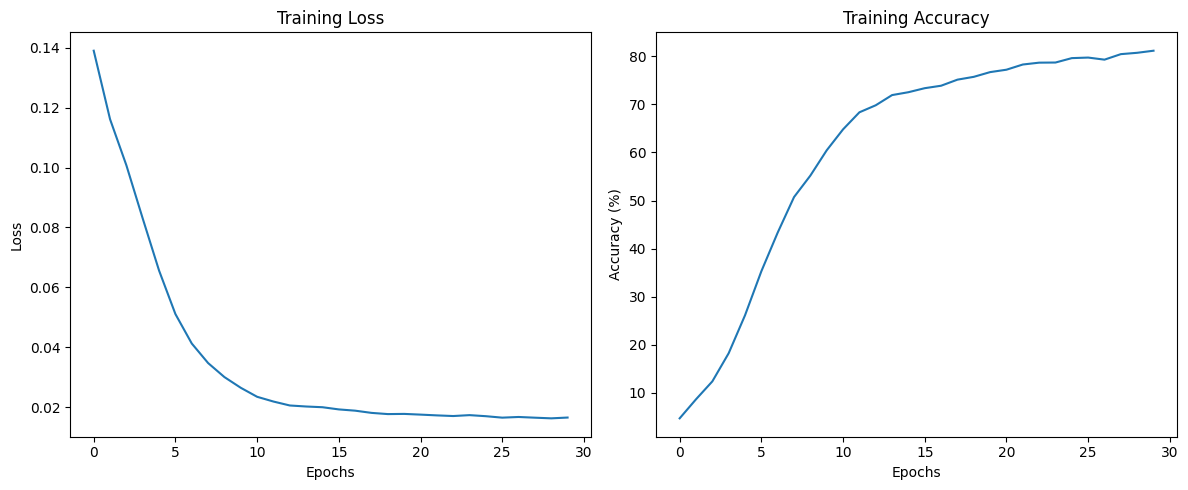

In [ ]:
# Plotting the training losses and accuracies
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()

Training Accuracy

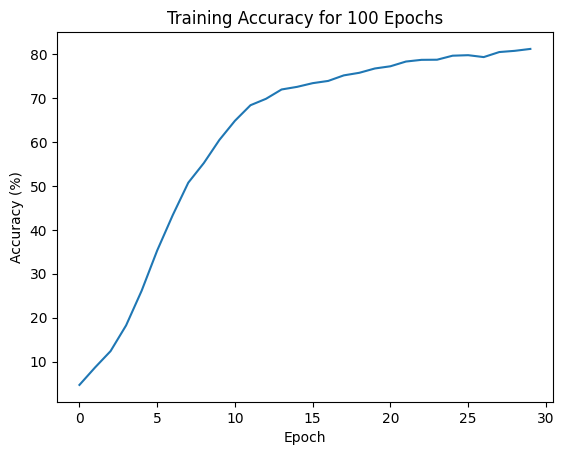

In [ ]:
# Plot Accuracy
plt.plot(train_accuracies)
plt.title('Training Accuracy for 100 Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.show()

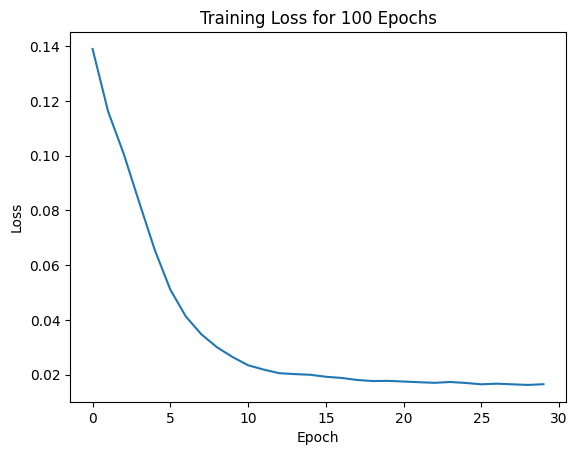

In [ ]:
# Plot Loss
plt.plot(train_losses)
plt.title('Training Loss for 100 Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

## Visualize forgetting count

Each data point had a forgetting count in the range of 0 to 26

In [ ]:
#forgetting events: unique count
np.unique(T)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 17., 19.,
       26.])

Plot the number of data points for each unique forgetting count

The histogram shows how many data points were forgotten 0,1,2... times

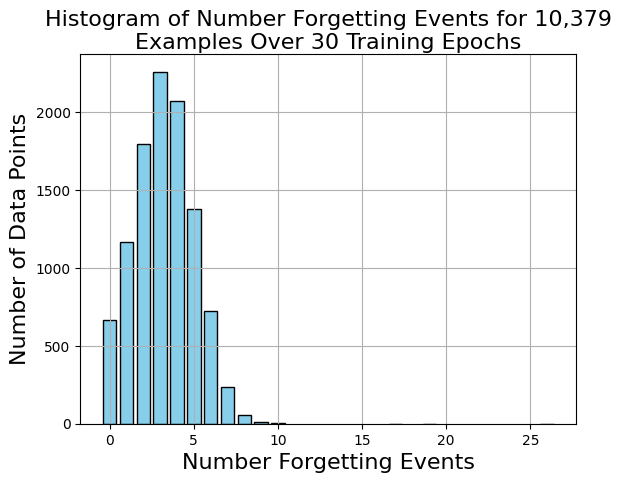

In [ ]:
# Count how many points were forgotten 0, 1, 2, ... times
unique_T, counts = np.unique(T, return_counts=True)

# Plot histogram of how many points were forgotten 1, 2, ... times
#plt.figure(figsize=(8, 5))
plt.bar(unique_T, counts, color='skyblue', edgecolor='black')
plt.title('Histogram of Number Forgetting Events for 10,379 Examples Over 30 Training Epochs',fontsize=16, wrap=True)
plt.xlabel('Number Forgetting Events',fontsize=16)
plt.ylabel('Number of Data Points',fontsize=16)
#plt.xticks(unique_T)  # Ensure all unique counts are labeled
plt.grid(True)
plt.show()


Plot same histogram but for the fraction of the training dataset

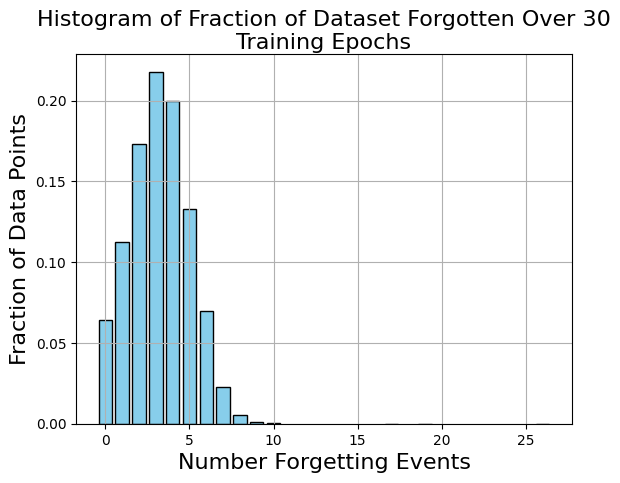

In [ ]:
# Proportion of dataset that were forgotten 0, 1, 2, ... times
unique_T, counts = np.unique(T, return_counts=True)

counts = counts / counts.sum()

# Plot histogram of how many points were forgotten 1, 2, ... times
plt.bar(unique_T, counts, color='skyblue', edgecolor='black')
plt.title('Histogram of Fraction of Dataset Forgotten Over 30 Training Epochs',fontsize=16, wrap=True)
plt.xlabel('Number Forgetting Events',fontsize=16)
plt.ylabel('Fraction of Data Points',fontsize=16)
#plt.xticks(unique_T)  # Ensure all unique counts are labeled
plt.grid(True)
plt.show()


## Forgetting counts for 100 training iterations

In [ ]:
T, acc, train_accuracies, train_losses = train_and_count_forgetting_events(100)

Epoch 1/100, Loss: 0.1391, Accuracy: 4.68%
Epoch 2/100, Loss: 0.1164, Accuracy: 8.77%
Epoch 3/100, Loss: 0.1010, Accuracy: 12.44%
Epoch 4/100, Loss: 0.0837, Accuracy: 17.57%
Epoch 5/100, Loss: 0.0666, Accuracy: 25.68%
Epoch 6/100, Loss: 0.0521, Accuracy: 34.80%
Epoch 7/100, Loss: 0.0415, Accuracy: 43.95%
Epoch 8/100, Loss: 0.0356, Accuracy: 48.94%
Epoch 9/100, Loss: 0.0310, Accuracy: 53.54%
Epoch 10/100, Loss: 0.0269, Accuracy: 60.12%
Epoch 11/100, Loss: 0.0239, Accuracy: 64.15%
Epoch 12/100, Loss: 0.0220, Accuracy: 67.23%
Epoch 13/100, Loss: 0.0209, Accuracy: 69.06%
Epoch 14/100, Loss: 0.0201, Accuracy: 71.42%
Epoch 15/100, Loss: 0.0197, Accuracy: 71.76%
Epoch 16/100, Loss: 0.0192, Accuracy: 73.09%
Epoch 17/100, Loss: 0.0189, Accuracy: 73.79%
Epoch 18/100, Loss: 0.0183, Accuracy: 74.54%
Epoch 19/100, Loss: 0.0184, Accuracy: 75.40%
Epoch 20/100, Loss: 0.0180, Accuracy: 76.02%
Epoch 21/100, Loss: 0.0174, Accuracy: 77.14%
Epoch 22/100, Loss: 0.0174, Accuracy: 77.50%
Epoch 23/100, Loss: 0

In [ ]:
test_accuracy(model)

100% Test Accuracy: 7.37%
95% Test Accuracy: 71.96%
90% Test Accuracy: 94.29%
75% Test Accuracy: 100.00%


Histogram for number of data points for each forgetting count

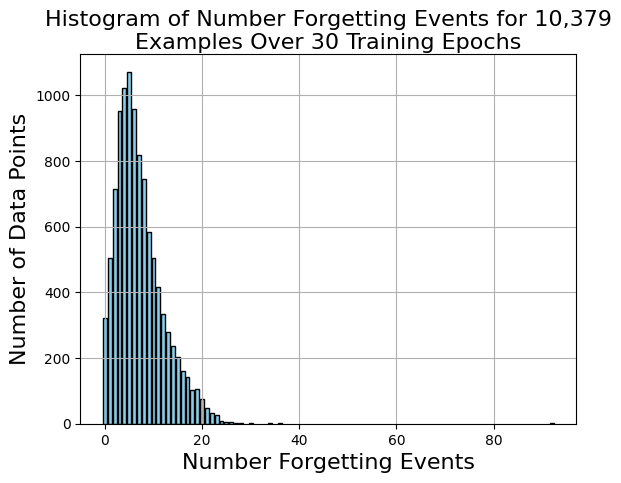

In [ ]:
# Count how many points were forgotten 0, 1, 2, ... times
unique_T, counts = np.unique(T, return_counts=True)

# Plot histogram of how many points were forgotten 1, 2, ... times
plt.bar(unique_T, counts, color='skyblue', edgecolor='black')
plt.title('Histogram of Number Forgetting Events for 10,379 Examples Over 30 Training Epochs',fontsize=16, wrap=True)
plt.xlabel('Number Forgetting Events',fontsize=16)
plt.ylabel('Number of Data Points',fontsize=16)
plt.grid(True)
plt.show()


Histogram for fraction of dataset instead of number of data points

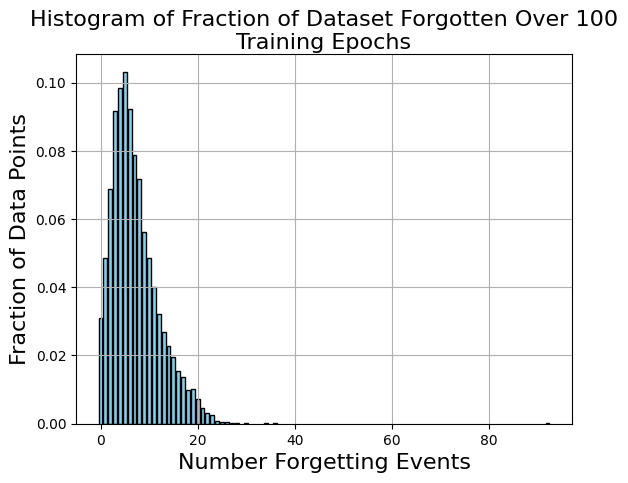

In [ ]:
# Proportion of dataset that were forgotten 0, 1, 2, ... times
unique_T, counts = np.unique(T, return_counts=True)

counts = counts / counts.sum()

# Plot histogram of how many points were forgotten 1, 2, ... times
plt.bar(unique_T, counts, color='skyblue', edgecolor='black')
plt.title('Histogram of Fraction of Dataset Forgotten Over 100 Training Epochs',fontsize=16, wrap=True)
plt.xlabel('Number Forgetting Events',fontsize=16)
plt.ylabel('Fraction of Data Points',fontsize=16)
plt.grid(True)
plt.show()


# Experiment: Random seeds

The function runs the experiment to count forgetting events for a random seed parameter

The model is reset each time, and run for 30 epochs

In [ ]:
def train_random_seed(seed):

  model = ClassifierD3(2000, 5000, 71).to(device)
  criterion = nn.BCEWithLogitsLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.005)


  # Set random seed for reproducibility
  random.seed(seed)  # Python's built-in random module
  np.random.seed(seed)  # NumPy random generator
  torch.manual_seed(seed)  # PyTorch random generator for CPU
  torch.cuda.manual_seed_all(seed)  # PyTorch random generator for all GPUs (if applicable)

  # Initialize lists to store metrics
  train_losses = []
  train_accuracies = []

  # Number of training samples
  n = len(train_dataset)

  # Initialize acc and T arrays
  acc = np.zeros(n, dtype=int)  # 0 = misclassified, 1 = correctly classified
  T = np.zeros(n, dtype=int)     # count forgetting events

  # Training loop
  num_epochs = 30
  for epoch in range(num_epochs):
      model.train()
      total_loss = 0
      correct_preds = 0
      total_samples = 0

      for batch_idx, (features, labels) in enumerate(train_loader):
          features, labels = features.to(device), labels.to(device)  # Move to GPU or CPU
          batch_size = features.size(0)
          batch_start = batch_idx * batch_size
          batch_indices = np.arange(batch_start, batch_start + batch_size)

          optimizer.zero_grad()
          outputs = model(features)

          # Calculate loss
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          total_loss += loss.item()

          # Predictions and misclassification tracking
          predicted = (torch.sigmoid(outputs) > 0.5).int()  # Multi-label classification
          correct = (predicted == labels).int()

          for i, idx in enumerate(batch_indices):
              if acc[idx] == 1 and correct[i].sum().item() < labels.size(1):  # If went from correct -> incorrect
                  T[idx] += 1
              acc[idx] = int(correct[i].sum().item() == labels.size(1))  # 1 if all labels correct, else 0

          # Calculate accuracy for multi-label classification with a 90% threshold
          correct_preds_batch = (correct.sum(dim=1) >= (labels.size(1) * 1)).sum().item()  # At least 90% of labels correct
          correct_preds += correct_preds_batch
          total_samples += labels.size(0)

      avg_loss = total_loss / len(train_loader)
      accuracy = correct_preds / total_samples * 100

      # Append the metrics to lists
      train_losses.append(avg_loss)
      train_accuracies.append(accuracy)

      print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

  #print("Training complete!")
  #print("Forgetting counts (T):", T)
  #print("Final classification status (acc):", acc)
  return T, acc



Run the experiment 10 times for random seeds between (1,20)

In [ ]:
T_aggregate = []
acc_aggregate = []
for seed in range (1,20,2):
  print("Seed: ", seed,"\n\n")
  T, acc = train_random_seed(seed)
  T_aggregate.append(T)
  #print(seed)


Seed:  1 


Epoch 1/30, Loss: 0.1392, Accuracy: 4.56%
Epoch 2/30, Loss: 0.1163, Accuracy: 8.81%
Epoch 3/30, Loss: 0.1011, Accuracy: 12.42%
Epoch 4/30, Loss: 0.0840, Accuracy: 17.89%
Epoch 5/30, Loss: 0.0663, Accuracy: 25.94%
Epoch 6/30, Loss: 0.0519, Accuracy: 35.43%
Epoch 7/30, Loss: 0.0416, Accuracy: 43.31%
Epoch 8/30, Loss: 0.0352, Accuracy: 50.41%
Epoch 9/30, Loss: 0.0309, Accuracy: 54.29%
Epoch 10/30, Loss: 0.0268, Accuracy: 59.11%
Epoch 11/30, Loss: 0.0239, Accuracy: 63.84%
Epoch 12/30, Loss: 0.0218, Accuracy: 67.68%
Epoch 13/30, Loss: 0.0208, Accuracy: 69.71%
Epoch 14/30, Loss: 0.0199, Accuracy: 71.02%
Epoch 15/30, Loss: 0.0191, Accuracy: 73.09%
Epoch 16/30, Loss: 0.0188, Accuracy: 73.59%
Epoch 17/30, Loss: 0.0181, Accuracy: 74.37%
Epoch 18/30, Loss: 0.0179, Accuracy: 75.46%
Epoch 19/30, Loss: 0.0182, Accuracy: 75.25%
Epoch 20/30, Loss: 0.0177, Accuracy: 76.48%
Epoch 21/30, Loss: 0.0178, Accuracy: 77.05%
Epoch 22/30, Loss: 0.0172, Accuracy: 78.09%
Epoch 23/30, Loss: 0.0174, Accu

Calculate the average Pearson correlation:

Calculate Pearson correlation between number of forgetting events for each data point across each model run

There are 10 arrays that store the forgetting counts from 10 model runs

The Pearson correlation is calculated between each array, and the average is calculated of all correlation values

In [ ]:
pearson_correlation_aggregate = [] # store the correlation for forgetting counts for data points between each model run
for i in range(len(T_aggregate)):
  for j in range(len(T_aggregate)):
    if i < j: # Don't compare the same two arrays
      forgetting_events_seed1 = np.array(T_aggregate[i])
      forgetting_events_seed2 = np.array(T_aggregate[j])

      mean1 = np.mean(forgetting_events_seed1)
      mean2 = np.mean(forgetting_events_seed2)

      cov = np.mean((forgetting_events_seed1 - mean1) * (forgetting_events_seed2 - mean2))

      std1 = np.std(forgetting_events_seed1)
      std2 = np.std(forgetting_events_seed2)

      # Compute Pearson correlation
      corr = cov / (std1 * std2)

      #print(f"Pearson correlation coefficient: {corr:.4f}")

      pearson_correlation_aggregate.append(corr)
average_corr = np.mean(pearson_correlation_aggregate)

print(f"Average Pearson correlation coefficient: {average_corr:.4f}")



Average Pearson correlation coefficient: 0.5250


Plot the histogram of forgetting counts for the first 5 seeds

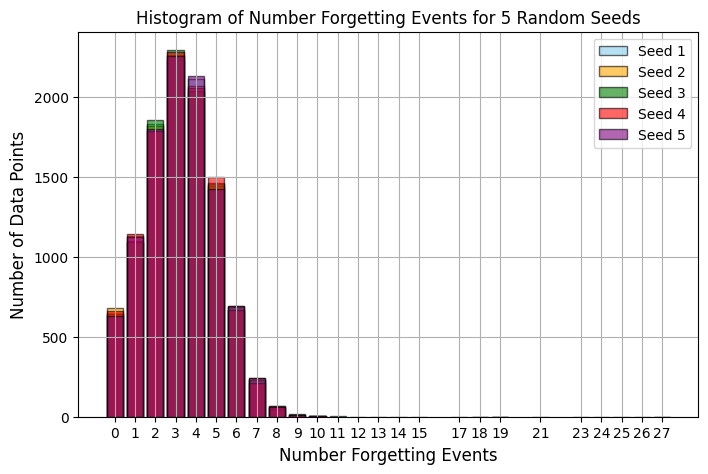

In [ ]:
unique_T, counts = np.unique(T_aggregate[0], return_counts=True)

unique_T2, counts2 = np.unique(T_aggregate[1], return_counts=True)

unique_T3, counts3 = np.unique(T_aggregate[2], return_counts=True)

unique_T4, counts4 = np.unique(T_aggregate[3], return_counts=True)

unique_T5, counts5 = np.unique(T_aggregate[4], return_counts=True)


plt.figure(figsize=(8, 5))

plt.bar(unique_T, counts, color='skyblue', edgecolor='black', label='Seed 1', alpha=0.6)

plt.bar(unique_T2, counts2, color='orange', edgecolor='black', label='Seed 2', alpha=0.6)

plt.bar(unique_T3, counts3, color='green', edgecolor='black', label='Seed 3', alpha=0.6)

plt.bar(unique_T4, counts4, color='red', edgecolor='black', label='Seed 4', alpha=0.6)

plt.bar(unique_T5, counts5, color='purple', edgecolor='black', label='Seed 5', alpha=0.6)

plt.xticks(np.union1d(np.union1d(np.union1d(np.union1d(unique_T, unique_T2), unique_T3), unique_T4), unique_T5))
plt.title('Histogram of Number Forgetting Events for 5 Random Seeds',fontsize=12, wrap=True)
plt.xlabel('Number Forgetting Events',fontsize=12)
plt.ylabel('Number of Data Points',fontsize=12)
plt.grid(True)

plt.legend()

plt.show()


Print tabular data used in histograms to compare the values

The data shows that each model run had very similar number of data points
(y-axis) forgetton for each forgetting count (x-axis)

In [ ]:
# print tabular data
for i in T_aggregate:
  unique_T, counts = np.unique(T, return_counts=True)
 # print("\n\n")
  for i in range(len(counts)):
    print( "Forgetting event: ", unique_T[i], " count: ", counts[i])


Forgetting event:  0  count:  638
Forgetting event:  1  count:  1126
Forgetting event:  2  count:  1869
Forgetting event:  3  count:  2231
Forgetting event:  4  count:  2123
Forgetting event:  5  count:  1404
Forgetting event:  6  count:  712
Forgetting event:  7  count:  209
Forgetting event:  8  count:  52
Forgetting event:  9  count:  7
Forgetting event:  10  count:  3
Forgetting event:  11  count:  1
Forgetting event:  12  count:  1
Forgetting event:  20  count:  1
Forgetting event:  22  count:  1
Forgetting event:  24  count:  1
Forgetting event:  0  count:  638
Forgetting event:  1  count:  1126
Forgetting event:  2  count:  1869
Forgetting event:  3  count:  2231
Forgetting event:  4  count:  2123
Forgetting event:  5  count:  1404
Forgetting event:  6  count:  712
Forgetting event:  7  count:  209
Forgetting event:  8  count:  52
Forgetting event:  9  count:  7
Forgetting event:  10  count:  3
Forgetting event:  11  count:  1
Forgetting event:  12  count:  1
Forgetting event:  

Calculate correlation between unique values (this histogram):

The first correlation claculation calculated the correlation between the forgetting count for each data point.

The below correlation is between the total number of data points forgotten for each forgetting count

In [ ]:
counts_aggregate = []
for i in T_aggregate:
  unique_T, counts = np.unique(T, return_counts=True)
  counts_aggregate.append(counts)

pearson_correlation_aggregate = []
for i in range(len(counts_aggregate)):
  for j in range(len(counts_aggregate)):
    if i < j:
      forgetting_events_seed1 = np.array(counts_aggregate[i])
      forgetting_events_seed2 = np.array(counts_aggregate[j])

      mean1 = np.mean(forgetting_events_seed1)
      mean2 = np.mean(forgetting_events_seed2)

      cov = np.mean((forgetting_events_seed1 - mean1) * (forgetting_events_seed2 - mean2))

      std1 = np.std(forgetting_events_seed1)
      std2 = np.std(forgetting_events_seed2)

      # Compute Pearson correlation
      corr = cov / (std1 * std2)

      #print(f"Pearson correlation coefficient: {corr:.4f}")

      pearson_correlation_aggregate.append(corr)
average_corr = np.mean(pearson_correlation_aggregate)

print(f"Average Pearson correlation coefficient: {average_corr:.4f}")



Average Pearson correlation coefficient: 1.0000


In [ ]:
events_aggregate = []
for i in T_aggregate:
  unique_T, counts = np.unique(T, return_counts=True)
  events_aggregate.append(unique_T)

pearson_correlation_aggregate = []
for i in range(len(events_aggregate)):
  for j in range(len(events_aggregate)):
    if i < j:
      forgetting_events_seed1 = np.array(events_aggregate[i])
      forgetting_events_seed2 = np.array(events_aggregate[j])

      mean1 = np.mean(forgetting_events_seed1)
      mean2 = np.mean(forgetting_events_seed2)

      cov = np.mean((forgetting_events_seed1 - mean1) * (forgetting_events_seed2 - mean2))

      std1 = np.std(forgetting_events_seed1)
      std2 = np.std(forgetting_events_seed2)

      # Compute Pearson correlation
      corr = cov / (std1 * std2)

      #print(f"Pearson correlation coefficient: {corr:.4f}")

      pearson_correlation_aggregate.append(corr)
average_corr = np.mean(pearson_correlation_aggregate)

print(f"Average Pearson correlation coefficient: {average_corr:.4f}")



Average Pearson correlation coefficient: 1.0000


The forgetting counts (ie. forgotten 1,2,...) also remained the same

# Experiment: Remove unforgettable data points

Remove subsets of the data and evaluate the model performance

In [ ]:
# train and test results using all data
T, acc, train_accuracies, train_losses = train_and_count_forgetting_events(30)
test_accuracy(model)

Epoch 1/30, Loss: 0.1391, Accuracy: 4.78%
Epoch 2/30, Loss: 0.1162, Accuracy: 8.86%
Epoch 3/30, Loss: 0.1007, Accuracy: 12.39%
Epoch 4/30, Loss: 0.0831, Accuracy: 17.91%
Epoch 5/30, Loss: 0.0656, Accuracy: 26.32%
Epoch 6/30, Loss: 0.0514, Accuracy: 35.45%
Epoch 7/30, Loss: 0.0411, Accuracy: 43.94%
Epoch 8/30, Loss: 0.0356, Accuracy: 49.64%
Epoch 9/30, Loss: 0.0306, Accuracy: 54.73%
Epoch 10/30, Loss: 0.0262, Accuracy: 61.33%
Epoch 11/30, Loss: 0.0240, Accuracy: 64.38%
Epoch 12/30, Loss: 0.0221, Accuracy: 67.68%
Epoch 13/30, Loss: 0.0209, Accuracy: 70.11%
Epoch 14/30, Loss: 0.0199, Accuracy: 71.14%
Epoch 15/30, Loss: 0.0194, Accuracy: 72.21%
Epoch 16/30, Loss: 0.0189, Accuracy: 73.48%
Epoch 17/30, Loss: 0.0186, Accuracy: 73.93%
Epoch 18/30, Loss: 0.0181, Accuracy: 75.03%
Epoch 19/30, Loss: 0.0178, Accuracy: 76.24%
Epoch 20/30, Loss: 0.0182, Accuracy: 76.12%
Epoch 21/30, Loss: 0.0178, Accuracy: 77.01%
Epoch 22/30, Loss: 0.0174, Accuracy: 77.37%
Epoch 23/30, Loss: 0.0167, Accuracy: 78.13%

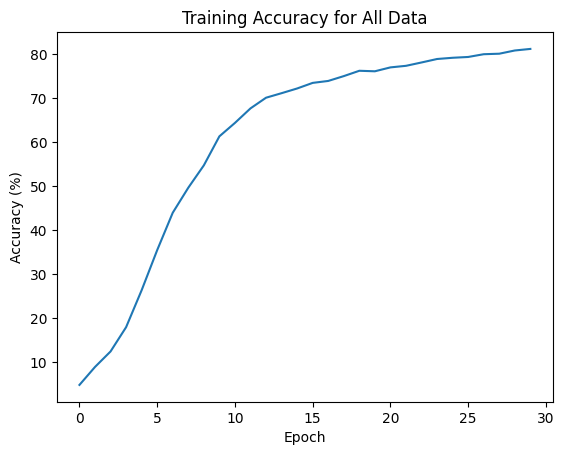

In [ ]:
# Plot Accuracy
plt.plot(train_accuracies)
plt.title('Training Accuracy for All Data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.show()

In [ ]:
# get the indicies of data points that match the filter
unforgettable_0 = np.where(T == 0)[0] # data points never forgotten
unforgettable_1 = np.where(T <= 1)[0] # data points forgotten 0 or once
unforgettable_2 = np.where(T <= 1)[0] # data points forgotten 0 or once

forgettable_all = np.where(T > 0)[0] # data forgotten at least once
forgettable__5 = np.where(T > 5)[0] # data forgotten more than 5 times
unforgettable_0

array([   17,    29,    35,    37,    49,    75,    86,   134,   141,
         145,   175,   177,   179,   222,   230,   243,   252,   272,
         295,   300,   329,   331,   340,   343,   352,   367,   390,
         427,   432,   447,   467,   483,   488,   505,   506,   528,
         541,   576,   602,   606,   623,   632,   659,   661,   674,
         685,   689,   691,   723,   728,   734,   790,   794,   806,
         846,   848,   855,   856,   892,   894,   923,   925,   928,
         940,   948,   958,   960,   969,   986,  1012,  1023,  1024,
        1028,  1073,  1079,  1130,  1141,  1148,  1170,  1192,  1209,
        1216,  1229,  1250,  1284,  1302,  1336,  1348,  1367,  1376,
        1386,  1387,  1388,  1427,  1478,  1500,  1522,  1525,  1529,
        1535,  1557,  1600,  1603,  1615,  1680,  1691,  1705,  1739,
        1743,  1804,  1829,  1846,  1854,  1856,  1891,  1893,  1896,
        1943,  1947,  1966,  2012,  2028,  2033,  2046,  2054,  2059,
        2109,  2121,

Train on only unforgettable data

In [ ]:
#Unfrogettable dataset size:
len(unforgettable_0)

651

In [ ]:
# create new dataset that only includes unforgettable data
vectorizer = TfidfVectorizer(max_features=2000)
train_features = vectorizer.fit_transform([train_texts[i] for i in unforgettable_0]).toarray()
val_features = vectorizer.transform(val_texts).toarray()
test_features = vectorizer.transform(test_texts).toarray()

# Convert to tensors
train_features_tensor = torch.tensor(train_features, dtype=torch.float32)
val_features_tensor = torch.tensor(val_features, dtype=torch.float32)
test_features_tensor = torch.tensor(test_features, dtype=torch.float32)
#train model

class IMDBDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Create datasets
train_dataset = IMDBDataset(train_features_tensor, train_labels)
val_dataset = IMDBDataset(val_features_tensor, val_labels)
test_dataset = IMDBDataset(test_features_tensor, test_labels)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)


In [ ]:
T, acc, train_accuracies, train_losses = train_and_count_forgetting_events(30)
test_accuracy(model)

Epoch 1/30, Loss: 0.2380, Accuracy: 1.54%
Epoch 2/30, Loss: 0.1493, Accuracy: 0.46%
Epoch 3/30, Loss: 0.1353, Accuracy: 0.92%
Epoch 4/30, Loss: 0.1232, Accuracy: 6.30%
Epoch 5/30, Loss: 0.1047, Accuracy: 12.75%
Epoch 6/30, Loss: 0.0828, Accuracy: 20.74%
Epoch 7/30, Loss: 0.0644, Accuracy: 32.41%
Epoch 8/30, Loss: 0.0512, Accuracy: 46.24%
Epoch 9/30, Loss: 0.0465, Accuracy: 50.54%
Epoch 10/30, Loss: 0.0457, Accuracy: 44.39%
Epoch 11/30, Loss: 0.0433, Accuracy: 46.08%
Epoch 12/30, Loss: 0.0399, Accuracy: 53.61%
Epoch 13/30, Loss: 0.0352, Accuracy: 60.37%
Epoch 14/30, Loss: 0.0289, Accuracy: 69.59%
Epoch 15/30, Loss: 0.0252, Accuracy: 73.73%
Epoch 16/30, Loss: 0.0242, Accuracy: 74.81%
Epoch 17/30, Loss: 0.0252, Accuracy: 75.73%
Epoch 18/30, Loss: 0.0257, Accuracy: 75.58%
Epoch 19/30, Loss: 0.0235, Accuracy: 75.73%
Epoch 20/30, Loss: 0.0246, Accuracy: 76.34%
Epoch 21/30, Loss: 0.0245, Accuracy: 76.04%
Epoch 22/30, Loss: 0.0239, Accuracy: 76.34%
Epoch 23/30, Loss: 0.0246, Accuracy: 76.80%
E

Run time was 5.5 seconds

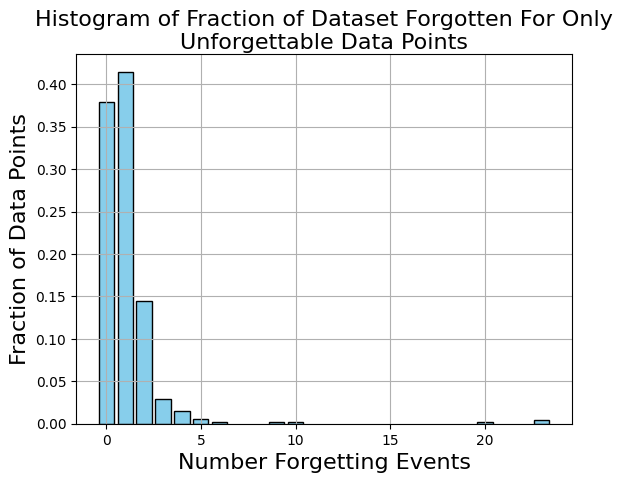

In [ ]:
# Proportion of dataset that were forgotten 0, 1, 2, ... times
unique_T, counts = np.unique(T, return_counts=True)

counts = counts / counts.sum()

# Plot histogram of how many points were forgotten 1, 2, ... times
plt.bar(unique_T, counts, color='skyblue', edgecolor='black')
plt.title('Histogram of Fraction of Dataset Forgotten For Only Unforgettable Data Points',fontsize=16, wrap=True)
plt.xlabel('Number Forgetting Events',fontsize=16)
plt.ylabel('Fraction of Data Points',fontsize=16)
#plt.xticks(unique_T)  # Ensure all unique counts are labeled
plt.grid(True)
plt.show()


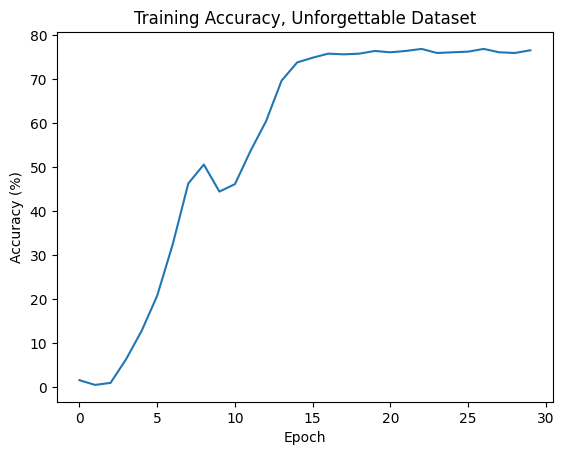

In [ ]:
# Plot Accuracy
plt.plot(train_accuracies)
plt.title('Training Accuracy, Unforgettable Dataset')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.show()

All forgettable data

In [ ]:
#Unfrogettable dataset size:
len(unforgettable_1)

1755

In [ ]:
vectorizer = TfidfVectorizer(max_features=2000)
train_features = vectorizer.fit_transform([train_texts[i] for i in unforgettable_1]).toarray()
val_features = vectorizer.transform(val_texts).toarray()
test_features = vectorizer.transform(test_texts).toarray()

# Convert to tensors
train_features_tensor = torch.tensor(train_features, dtype=torch.float32)
val_features_tensor = torch.tensor(val_features, dtype=torch.float32)
test_features_tensor = torch.tensor(test_features, dtype=torch.float32)
#train model

class IMDBDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Create datasets
train_dataset = IMDBDataset(train_features_tensor, train_labels)
val_dataset = IMDBDataset(val_features_tensor, val_labels)
test_dataset = IMDBDataset(test_features_tensor, test_labels)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)


In [ ]:
T, acc, train_accuracies, train_losses = train_and_count_forgetting_events(30)
test_accuracy(model)

Epoch 1/30, Loss: 0.1845, Accuracy: 1.54%
Epoch 2/30, Loss: 0.1399, Accuracy: 1.08%
Epoch 3/30, Loss: 0.1276, Accuracy: 3.25%
Epoch 4/30, Loss: 0.1089, Accuracy: 7.69%
Epoch 5/30, Loss: 0.0840, Accuracy: 17.44%
Epoch 6/30, Loss: 0.0618, Accuracy: 32.19%
Epoch 7/30, Loss: 0.0463, Accuracy: 49.29%
Epoch 8/30, Loss: 0.0399, Accuracy: 56.07%
Epoch 9/30, Loss: 0.0391, Accuracy: 56.81%
Epoch 10/30, Loss: 0.0397, Accuracy: 54.30%
Epoch 11/30, Loss: 0.0352, Accuracy: 62.39%
Epoch 12/30, Loss: 0.0296, Accuracy: 70.71%
Epoch 13/30, Loss: 0.0264, Accuracy: 77.89%
Epoch 14/30, Loss: 0.0254, Accuracy: 79.32%
Epoch 15/30, Loss: 0.0253, Accuracy: 78.40%
Epoch 16/30, Loss: 0.0250, Accuracy: 80.23%
Epoch 17/30, Loss: 0.0233, Accuracy: 80.63%
Epoch 18/30, Loss: 0.0235, Accuracy: 80.91%
Epoch 19/30, Loss: 0.0232, Accuracy: 81.31%
Epoch 20/30, Loss: 0.0232, Accuracy: 81.31%
Epoch 21/30, Loss: 0.0230, Accuracy: 81.48%
Epoch 22/30, Loss: 0.0227, Accuracy: 81.48%
Epoch 23/30, Loss: 0.0226, Accuracy: 81.54%
E

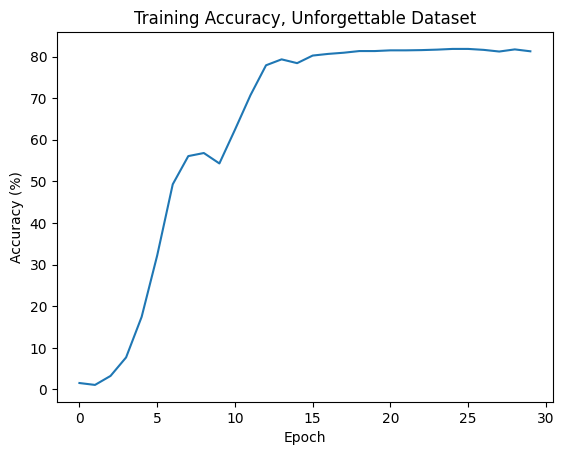

In [ ]:
# Plot Accuracy
plt.plot(train_accuracies)
plt.title('Training Accuracy, Dataset: ')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.show()

In [ ]:
len(unforgettable_2)

1755

In [ ]:
vectorizer = TfidfVectorizer(max_features=2000)
train_features = vectorizer.fit_transform([train_texts[i] for i in unforgettable_2]).toarray()
val_features = vectorizer.transform(val_texts).toarray()
test_features = vectorizer.transform(test_texts).toarray()

# Convert to tensors
train_features_tensor = torch.tensor(train_features, dtype=torch.float32)
val_features_tensor = torch.tensor(val_features, dtype=torch.float32)
test_features_tensor = torch.tensor(test_features, dtype=torch.float32)
#train model

class IMDBDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Create datasets
train_dataset = IMDBDataset(train_features_tensor, train_labels)
val_dataset = IMDBDataset(val_features_tensor, val_labels)
test_dataset = IMDBDataset(test_features_tensor, test_labels)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)


In [ ]:
T, acc, train_accuracies, train_losses = train_and_count_forgetting_events(30)
test_accuracy(model)

Epoch 1/30, Loss: 0.1847, Accuracy: 1.54%
Epoch 2/30, Loss: 0.1401, Accuracy: 0.74%
Epoch 3/30, Loss: 0.1275, Accuracy: 3.42%
Epoch 4/30, Loss: 0.1090, Accuracy: 6.21%
Epoch 5/30, Loss: 0.0846, Accuracy: 16.52%
Epoch 6/30, Loss: 0.0622, Accuracy: 31.00%
Epoch 7/30, Loss: 0.0468, Accuracy: 49.12%
Epoch 8/30, Loss: 0.0404, Accuracy: 54.87%
Epoch 9/30, Loss: 0.0400, Accuracy: 55.73%
Epoch 10/30, Loss: 0.0394, Accuracy: 53.28%
Epoch 11/30, Loss: 0.0339, Accuracy: 62.45%
Epoch 12/30, Loss: 0.0295, Accuracy: 70.43%
Epoch 13/30, Loss: 0.0263, Accuracy: 76.58%
Epoch 14/30, Loss: 0.0258, Accuracy: 79.72%
Epoch 15/30, Loss: 0.0255, Accuracy: 79.94%
Epoch 16/30, Loss: 0.0249, Accuracy: 79.49%
Epoch 17/30, Loss: 0.0238, Accuracy: 80.63%
Epoch 18/30, Loss: 0.0233, Accuracy: 81.20%
Epoch 19/30, Loss: 0.0230, Accuracy: 81.42%
Epoch 20/30, Loss: 0.0232, Accuracy: 81.37%
Epoch 21/30, Loss: 0.0233, Accuracy: 81.71%
Epoch 22/30, Loss: 0.0235, Accuracy: 81.65%
Epoch 23/30, Loss: 0.0225, Accuracy: 81.42%
E

Run time 18.54 seconds

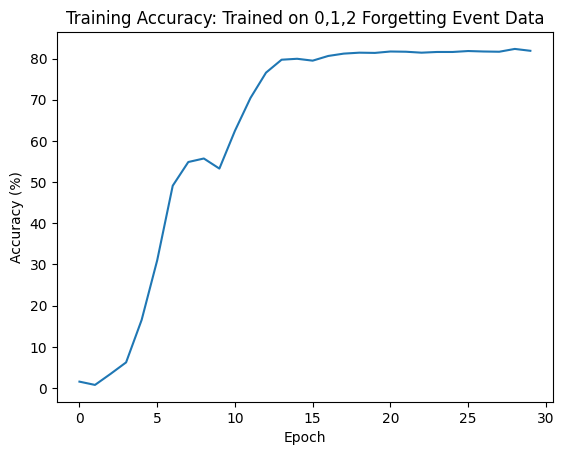

In [ ]:
# Plot Accuracy
plt.plot(train_accuracies)
plt.title('Training Accuracy: Trained on 0,1,2 Forgetting Event Data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.show()

In [ ]:
len(forgettable_all)

9728

In [ ]:
vectorizer = TfidfVectorizer(max_features=2000)
train_features = vectorizer.fit_transform([train_texts[i] for i in forgettable_all]).toarray()
val_features = vectorizer.transform(val_texts).toarray()
test_features = vectorizer.transform(test_texts).toarray()

# Convert to tensors
train_features_tensor = torch.tensor(train_features, dtype=torch.float32)
val_features_tensor = torch.tensor(val_features, dtype=torch.float32)
test_features_tensor = torch.tensor(test_features, dtype=torch.float32)
#train model

class IMDBDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Create datasets
train_dataset = IMDBDataset(train_features_tensor, train_labels)
val_dataset = IMDBDataset(val_features_tensor, val_labels)
test_dataset = IMDBDataset(test_features_tensor, test_labels)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)


In [ ]:
T, acc, train_accuracies, train_losses = train_and_count_forgetting_events(30)
test_accuracy(model)

Epoch 1/30, Loss: 0.1506, Accuracy: 0.43%
Epoch 2/30, Loss: 0.1399, Accuracy: 0.75%
Epoch 3/30, Loss: 0.1335, Accuracy: 1.80%
Epoch 4/30, Loss: 0.1213, Accuracy: 4.03%
Epoch 5/30, Loss: 0.1046, Accuracy: 7.78%
Epoch 6/30, Loss: 0.0859, Accuracy: 13.23%
Epoch 7/30, Loss: 0.0698, Accuracy: 21.35%
Epoch 8/30, Loss: 0.0565, Accuracy: 29.12%
Epoch 9/30, Loss: 0.0479, Accuracy: 35.90%
Epoch 10/30, Loss: 0.0412, Accuracy: 41.81%
Epoch 11/30, Loss: 0.0358, Accuracy: 47.74%
Epoch 12/30, Loss: 0.0323, Accuracy: 51.97%
Epoch 13/30, Loss: 0.0290, Accuracy: 56.85%
Epoch 14/30, Loss: 0.0271, Accuracy: 60.43%
Epoch 15/30, Loss: 0.0246, Accuracy: 63.84%
Epoch 16/30, Loss: 0.0234, Accuracy: 66.61%
Epoch 17/30, Loss: 0.0218, Accuracy: 69.11%
Epoch 18/30, Loss: 0.0215, Accuracy: 70.63%
Epoch 19/30, Loss: 0.0201, Accuracy: 71.47%
Epoch 20/30, Loss: 0.0206, Accuracy: 73.11%
Epoch 21/30, Loss: 0.0198, Accuracy: 73.41%
Epoch 22/30, Loss: 0.0196, Accuracy: 74.92%
Epoch 23/30, Loss: 0.0195, Accuracy: 74.93%
Ep

Train time: 1 min 5 seconds

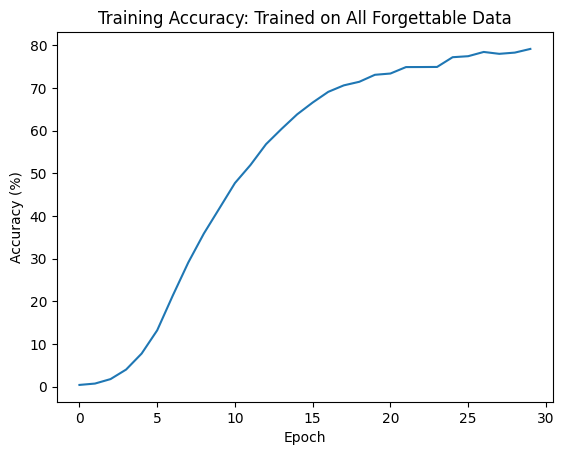

In [ ]:
# Plot Accuracy
plt.plot(train_accuracies)
plt.title('Training Accuracy: Trained on All Forgettable Data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.show()

In [ ]:
len(forgettable__5)

1019

In [ ]:
vectorizer = TfidfVectorizer(max_features=2000)
train_features = vectorizer.fit_transform([train_texts[i] for i in forgettable__5]).toarray()
val_features = vectorizer.transform(val_texts).toarray()
test_features = vectorizer.transform(test_texts).toarray()

# Convert to tensors
train_features_tensor = torch.tensor(train_features, dtype=torch.float32)
val_features_tensor = torch.tensor(val_features, dtype=torch.float32)
test_features_tensor = torch.tensor(test_features, dtype=torch.float32)
#train model

class IMDBDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Create datasets
train_dataset = IMDBDataset(train_features_tensor, train_labels)
val_dataset = IMDBDataset(val_features_tensor, val_labels)
test_dataset = IMDBDataset(test_features_tensor, test_labels)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)


In [ ]:
T, acc, train_accuracies, train_losses = train_and_count_forgetting_events(30)
test_accuracy(model)

Epoch 1/30, Loss: 0.2074, Accuracy: 0.98%
Epoch 2/30, Loss: 0.1434, Accuracy: 0.20%
Epoch 3/30, Loss: 0.1313, Accuracy: 1.57%
Epoch 4/30, Loss: 0.1187, Accuracy: 5.50%
Epoch 5/30, Loss: 0.1009, Accuracy: 11.78%
Epoch 6/30, Loss: 0.0811, Accuracy: 20.90%
Epoch 7/30, Loss: 0.0631, Accuracy: 28.95%
Epoch 8/30, Loss: 0.0503, Accuracy: 34.45%
Epoch 9/30, Loss: 0.0407, Accuracy: 43.96%
Epoch 10/30, Loss: 0.0339, Accuracy: 48.58%
Epoch 11/30, Loss: 0.0348, Accuracy: 52.01%
Epoch 12/30, Loss: 0.0247, Accuracy: 63.00%
Epoch 13/30, Loss: 0.0163, Accuracy: 81.26%
Epoch 14/30, Loss: 0.0118, Accuracy: 90.38%
Epoch 15/30, Loss: 0.0104, Accuracy: 91.36%
Epoch 16/30, Loss: 0.0099, Accuracy: 92.05%
Epoch 17/30, Loss: 0.0098, Accuracy: 92.44%
Epoch 18/30, Loss: 0.0098, Accuracy: 92.44%
Epoch 19/30, Loss: 0.0104, Accuracy: 92.25%
Epoch 20/30, Loss: 0.0090, Accuracy: 92.54%
Epoch 21/30, Loss: 0.0088, Accuracy: 92.93%
Epoch 22/30, Loss: 0.0082, Accuracy: 93.03%
Epoch 23/30, Loss: 0.0074, Accuracy: 93.72%
E

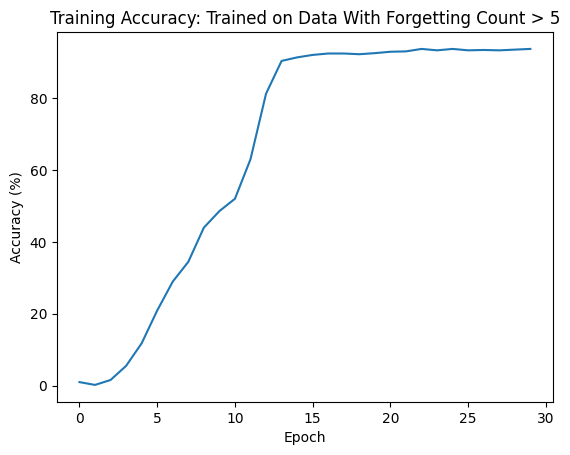

In [ ]:
# Plot Accuracy
plt.plot(train_accuracies)
plt.title('Training Accuracy: Trained on Data With Forgetting Count > 5')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.show()

#Experiment: Forgetting by Chance

In [ ]:
import copy
import random

In [ ]:
#initialize models with the same random weights
torch.manual_seed(424)
random.seed(424)
base_model = Classifier(13848, 71, labels.shape[1])
random_update_model = copy.deepcopy(base_model)
for param in random_update_model.parameters():
  param.requires_grad = False

In [ ]:
def update_shuffled_gradients(base_model, random_update_model, device, lr = 0.01):
  parameter_shapes = []
  parameter_index_locations = []
  total_num_gradients = 0
  for param in base_model.parameters():
    parameter_shapes.append(param.grad.shape)
    parameter_index_locations.append((total_num_gradients, total_num_gradients + torch.numel(param.grad)))
    total_num_gradients += torch.numel(param.grad)
  gradients = torch.empty(total_num_gradients)
  gradients = gradients.to(device)
  for param in base_model.parameters():
    gradients = torch.cat((gradients, torch.flatten(param.grad)))
  random_indices = torch.randperm(total_num_gradients)
  gradients = gradients[random_indices]
  current_param_index = 0
  for param in random_update_model.parameters():
    if current_param_index < len(parameter_shapes) - 1:
      gradient_data = gradients[parameter_index_locations[current_param_index][0]:\
                                parameter_index_locations[current_param_index][1]]
    else:
      gradient_data = gradients[parameter_index_locations[current_param_index][0]:]
    param -= lr * torch.reshape(gradient_data, parameter_shapes[current_param_index])
    current_param_index += 1

In [ ]:
#training function for base_model and random_update_model

def train_random_updates(base_model, random_update_model, num_epochs, device):
  # Initialize lists to store metrics
  base_model_losses = []
  base_model_accuracies = []
  random_model_accuracies = []

  # Move to appropriate device
  base_model.to(device)
  random_update_model.to(device)

  # Define optimizer and loss
  criterion = nn.BCEWithLogitsLoss()
  optimizer = optim.Adam(base_model.parameters(), lr=0.01)

  # Number of training samples
  n = len(train_dataset)

  # Initialize acc and T arrays
  acc_base = np.zeros(n, dtype=int)  # 0 = misclassified, 1 = correctly classified
  acc_random = np.zeros(n, dtype=int)
  T_base = np.zeros(n, dtype=int)     # count forgetting events
  T_random = np.zeros(n, dtype=int)

  # Training loop
  for epoch in range(num_epochs):
      base_model.train()
      total_loss = 0
      correct_preds_base = 0
      correct_preds_random = 0
      total_samples = 0

      for batch_idx, (features, labels) in enumerate(train_loader):
          features, labels = features.to(device), labels.to(device)  # Move to GPU or CPU
          batch_size = features.size(0)
          batch_start = batch_idx * batch_size
          batch_indices = np.arange(batch_start, batch_start + batch_size)

          optimizer.zero_grad()
          outputs_base = base_model(features)
          outputs_random = random_update_model(features)

          # Calculate loss
          loss = criterion(outputs_base, labels)
          loss.backward()
          # Update random_update model with shuffled gradients
          update_shuffled_gradients(base_model, random_update_model, device)
          optimizer.step()

          total_loss += loss.item()

          # Predictions and misclassification tracking
          predicted_base = (torch.sigmoid(outputs_base) > 0.5).int()  # Multi-label classification
          predicted_random = (torch.sigmoid(outputs_random) > 0.5).int()
          correct_base = (predicted_base == labels).int()
          correct_random = (predicted_random == labels).int()

          for i, idx in enumerate(batch_indices):
              if acc_base[idx] == 1 and correct_base[i].sum().item() < labels.size(1):  # If went from correct -> incorrect
                  T_base[idx] += 1
              if acc_random[idx] == 1 and correct_random[i].sum().item() < labels.size(1):
                  T_random[idx] += 1
              acc_base[idx] = int(correct_base[i].sum().item() == labels.size(1))  # 1 if all labels correct, else 0
              acc_random[idx] = int(correct_random[i].sum().item() == labels.size(1))

          # Calculate accuracy for multi-label classification with a 90% threshold
          #correct_preds_batch = (correct_base.sum(dim=1) >= (labels.size(1) * 1)).sum().item()  # At least 90% of labels correct_base
          #correct_preds += correct_preds_batch
          #total_samples += labels.size(0)

          correct_preds_batch_base = (predicted_base == labels).sum(dim = 1)  # For each sample in the batch
          correct_preds_batch_random = (predicted_random == labels).sum(dim = 1)

          # Check if at least 95% of genres are predicted correctly for each sample
          correct_preds_base += (correct_preds_batch_base >= (labels.size(1) * 1)).sum().item()  # At least 90% of genres predicted correctly
          correct_preds_random += (correct_preds_batch_random >= (labels.size(1) * 1)).sum().item()

          total_samples += labels.size(0)  # Total number of samples in batch (not total genres)

      base_model_loss = total_loss / len(train_loader)
      base_accuracy = correct_preds_base / total_samples * 100
      random_accuracy = correct_preds_random / total_samples * 100

      # Append the metrics to lists
      base_model_losses.append(base_model_loss)
      base_model_accuracies.append(base_accuracy)
      random_model_accuracies.append(random_accuracy)

      print(f"Epoch {epoch+1}/{num_epochs}, Loss: {base_model_loss:.4f}, Base Accuracy: {base_accuracy:.2f}%, Random Accuracy: {random_accuracy:.2f}%")

  print("Training complete!")
  print("Forgetting counts (T_base):", T_base)
  print("Forgetting counts (T_random):", T_random)
  print("Final classification status (acc_base):", acc_base)
  print("Final classification status (acc_random):", acc_random)
  return base_model_losses, base_model_accuracies, random_model_accuracies, T_base, T_random


In [ ]:
base_model_losses, base_model_accuracies, random_model_accuracies, \
T_base, T_random = train_random_updates(base_model, random_update_model, 30, "cuda")

Epoch 1/30, Loss: 0.1541, Base Accuracy: 1.20%, Random Accuracy: 0.00%
Epoch 2/30, Loss: 0.1232, Base Accuracy: 5.38%, Random Accuracy: 0.00%
Epoch 3/30, Loss: 0.1090, Base Accuracy: 8.72%, Random Accuracy: 0.00%
Epoch 4/30, Loss: 0.0976, Base Accuracy: 12.11%, Random Accuracy: 0.00%
Epoch 5/30, Loss: 0.0871, Base Accuracy: 16.64%, Random Accuracy: 0.00%
Epoch 6/30, Loss: 0.0783, Base Accuracy: 21.36%, Random Accuracy: 0.00%
Epoch 7/30, Loss: 0.0714, Base Accuracy: 24.44%, Random Accuracy: 0.00%
Epoch 8/30, Loss: 0.0660, Base Accuracy: 29.66%, Random Accuracy: 0.00%
Epoch 9/30, Loss: 0.0622, Base Accuracy: 33.12%, Random Accuracy: 0.00%
Epoch 10/30, Loss: 0.0593, Base Accuracy: 35.46%, Random Accuracy: 0.00%
Epoch 11/30, Loss: 0.0565, Base Accuracy: 38.65%, Random Accuracy: 0.00%
Epoch 12/30, Loss: 0.0550, Base Accuracy: 40.11%, Random Accuracy: 0.00%
Epoch 13/30, Loss: 0.0533, Base Accuracy: 41.75%, Random Accuracy: 0.00%
Epoch 14/30, Loss: 0.0526, Base Accuracy: 43.16%, Random Accura

In [ ]:
max(random_model_accuracies)

0.0

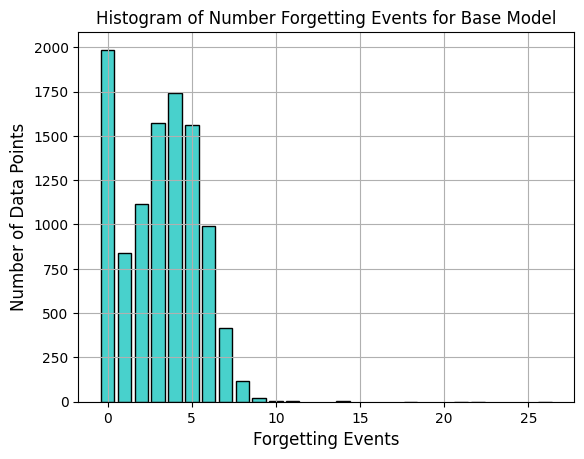

In [ ]:
# Count how many points were forgotten 0, 1, 2, ... times
unique_T_base, counts_base = np.unique(T_base, return_counts=True)

# Plot histogram of how many points were forgotten 1, 2, ... times
#plt.figure(figsize=(8, 5))
plt.bar(unique_T_base, counts_base, color='mediumturquoise', edgecolor='black')
plt.title('Histogram of Number Forgetting Events for Base Model',fontsize=12, wrap=True)
plt.xlabel('Forgetting Events',fontsize=12)
plt.ylabel('Number of Data Points',fontsize=12)
#plt.xticks(unique_T_base)  # Ensure all unique counts_base are labeled
plt.grid(True)
plt.show()


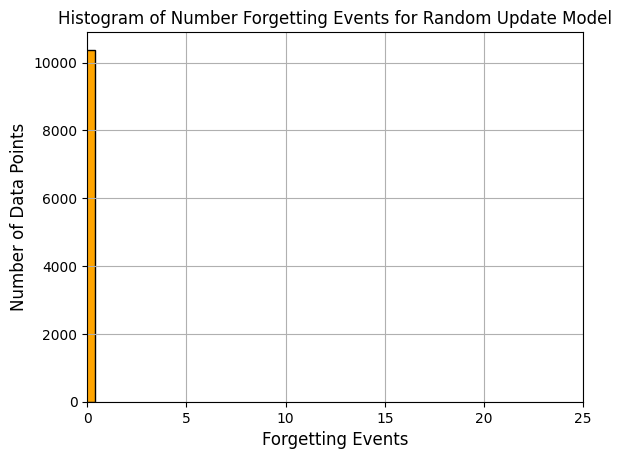

In [ ]:
# Count how many points were forgotten 0, 1, 2, ... times
unique_T_random, counts_random = np.unique(T_random, return_counts=True)

# Plot histogram of how many points were forgotten 1, 2, ... times
#plt.figure(figsize=(8, 5))
plt.bar(unique_T_random, counts_random, color='orange', edgecolor='black')
plt.title('Histogram of Number Forgetting Events for Random Update Model',fontsize=12, wrap=True)
plt.xlabel('Forgetting Events',fontsize=12)
plt.ylabel('Number of Data Points',fontsize=12)
plt.xlim(0, 25)
#plt.xticks(unique_T_random)  # Ensure all unique counts_random are labeled
plt.grid(True)
plt.show()


# Experiment: visual inspection

In [ ]:
genre_columns = df.columns[4:]

first_row_labels = df.iloc[0, 4:]  # Extract as a pandas Series

# Get column names where the value is 1
selected_genres = genre_columns[first_row_labels == 1].tolist()

print(selected_genres)


['atmospheric', 'cult', 'gothic', 'horror', 'murder']


## Check single datapoint by index, predicted label vs true label

In [ ]:
def predict(index):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  # Index of data point
  index = i

  # Get the text input and output
  sample_text = df.iloc[index]['plot_synopsis']
  actual_labels = df.iloc[index, 4:].values  # Extract actual genre labels

  sample_vector = vectorizer.transform([sample_text]).toarray()
  sample_tensor = torch.tensor(sample_vector, dtype=torch.float32)

  sample_tensor = sample_tensor.to(device) # set the data point to GPU

  model.eval()
  with torch.no_grad():
      predicted_output = model(sample_tensor)

  # Correct predictions
  predicted_labels = (predicted_output.cpu().numpy() > 0.5).astype(int)[0]  # Move to CPU before using numpy

  # Index the predicted genres
  genre_columns = df.columns[4:]  # Get genre column names
  actual_genres = genre_columns[actual_labels == 1].tolist()
  predicted_genres = genre_columns[predicted_labels == 1].tolist()

  print("\ntext input:", sample_text)
  print("actual genres---", actual_genres)
  print("predicted genres", predicted_genres)


In [ ]:
predict(0)

## Print out first 100 predictions/true labels

## Most forgotten example:
The training loop was run for 10 epochs, so the max possible number of forgetting events is 10.

In [ ]:
# Find the indices of the most and least forgotten samples
most_forgotten = np.argmax(T)
least_forgotten = np.argmin(T)

# Print out the most forgotten and least forgotten examples
print("Most forgotten example:")
predict(most_forgotten)

print("Least forgotten example: ")
predict(least_forgotten)



### Prediction for most forgotten example:
- very few data points were forgotten this many times, as seen in the graph in the training section

### Prediction for least forgotten example:

Explore more data points that were forgotten 9 times.

Explore more data points that were forgotten 8 times.

In [ ]:
# Get all indices where T is equal to the maximum and minimum values
idx = np.where(T == 8)[0]  # Indices with the maximum forgetting events

count = 0
# Print out the most forgotten and least forgotten examples
print("Most Forgotten Examples:")
for idx in most_forgotten_idx:
    print("Index ", idx, "Forget count ", T[idx])
    count += 1
    if count > 5:
      break



3 exmaples forgotten 5 times:

In [ ]:
# Get all indices where T is equal to the maximum and minimum values
idx = np.where(T == 5)[0]

count = 0
# Print out the most forgotten and least forgotten examples
print("Most Forgotten Examples:")
for idx in most_forgotten_idx:
    print("Index ", idx, "Forget count ", T[idx])
    count += 1
    if count > 5:
      break



In [ ]:
for i in [3819,8160,9923]:

  predict(i)


Inspect some examples that were never forgotten:

In [ ]:
# Get all indices where T is equal to the maximum and minimum values
idx = np.where(T == 0)[0]  # Indices with the maximum forgetting events

count = 0
# Print out the most forgotten and least forgotten examples
print("Most Forgotten Examples:")
for idx in most_forgotten_idx:
    print("Index ", idx, "Forget count ", T[idx])
    count += 1
    if count > 5:
      break



# Experiment: Graphs for Visualizing Metrics

In [ ]:
for num_forgets in range(T.max() + 1):
  print(f"One example was forgotten {num_forgets} times: {np.isin(num_forgets, T)}")

In [ ]:
#Graph avg description length vs num forgetting events
num_forgets_set = [0, 1, 2, 3, 4, 5, 7, 9, 10]

def get_avg_length_forgets(num_forgets_set):
  avg_synopsis_length = []
  for num_forgets in num_forgets_set:
    id_movies = np.where(T == num_forgets)[0]
    movies_synopses = df.loc[id_movies, "plot_synopsis"]
    movies_synopsis_length = movies_synopses.str.split(" ").str.len()
    avg_synopsis_length.append(np.mean(movies_synopsis_length))
  return avg_synopsis_length

get_avg_length_forgets(num_forgets_set)

In [ ]:
plt.figure()
plt.bar(num_forgets_set, get_avg_length_forgets(num_forgets_set))
plt.title("Avg Num Words vs. Num Forgetting Events")
plt.xlabel("Number of forgetting events")
plt.ylabel("Avg Num Words")
plt.xticks(num_forgets_set)
plt.grid(True)
plt.show()

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud_args = dict(
    width=1000,
    height=800,
    background_color='white',
    min_font_size=10
)

def plotWordCloud(dictionary, **kwargs):
    wordcloud = WordCloud(**kwargs)
    wordcloud.generate_from_frequencies(dictionary)
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Number of examples to use
num_examples = 30

# Function to get a 5-word snippet from a synopsis
def get_five_word_snippet(text):
    words = text.split()
    if len(words) < 5:
        return text.strip()
    return " ".join(words[:5])

# Most forgotten
most_idxs = np.argsort(-T)[:num_examples]
most_dict = {}
for idx in most_idxs:
    snippet = get_five_word_snippet(df.loc[idx, "plot_synopsis"])
    if snippet in most_dict:
        snippet += f" ({idx})"  # Ensure uniqueness if duplicate snippet
    most_dict[snippet] = T[idx]

print("🔴 Word Cloud for MOST Forgotten Examples")
plotWordCloud(most_dict, **wordcloud_args)

# Least forgotten (invert size: smallest T should be largest)
least_idxs = np.argsort(T)[:num_examples]
least_dict = {}
for i, idx in enumerate(least_idxs):
    snippet = get_five_word_snippet(df.loc[idx, "plot_synopsis"])
    if snippet in least_dict:
        snippet += f" ({idx})"
    least_dict[snippet] = num_examples - i  # Inverse rank for size

print("🟢 Word Cloud for LEAST Forgotten Examples")
plotWordCloud(least_dict, **wordcloud_args)

In [ ]:
# ----------------------------
# PMI Word Analysis for Most vs Least Forgotten Examples
# ----------------------------
from collections import Counter
import re
import math
from sklearn.feature_extraction.text import CountVectorizer

# Helper: get tokens from text
def tokenize(text):
    return [word.lower() for word in re.findall(r'\w+', text) if len(word) > 2]

# Get top indices
num_examples = 50
most_forgotten_idxs = np.argsort(-T)[:num_examples]
least_forgotten_idxs = np.argsort(T)[:num_examples]

# Create DataFrame with labels
df_pmi = pd.DataFrame({
    'text': df['plot_synopsis'],
    'label': ['forgotten' if i in most_forgotten_idxs else 'retained' if i in least_forgotten_idxs else None for i in range(len(df))]
})
df_pmi = df_pmi[df_pmi['label'].notnull()]

# Tokenize text
df_pmi['tokens'] = df_pmi['text'].apply(tokenize)

# Count word frequencies
def count_words(token_lists):
    counter = Counter()
    for tokens in token_lists:
        counter.update(tokens)
    return counter

forgotten_counts = count_words(df_pmi[df_pmi['label'] == 'forgotten']['tokens'])
retained_counts = count_words(df_pmi[df_pmi['label'] == 'retained']['tokens'])
total_counts = forgotten_counts + retained_counts
N = len(df_pmi)

# PMI Calculation
def compute_pmi(word, label, label_counts, total_counts, N_label, N_total):
    px = N_label / N_total
    py = total_counts[word] / N_total
    pxy = label_counts[word] / N_total
    if pxy == 0 or px == 0 or py == 0:
        return 0
    return math.log(pxy / (px * py))

# Total number of samples per class
N_forgotten = len(df_pmi[df_pmi['label'] == 'forgotten'])
N_retained = len(df_pmi[df_pmi['label'] == 'retained'])

# Compute PMI for top words in each group
top_words = set(list(forgotten_counts.keys()) + list(retained_counts.keys()))
pmi_forgotten = {}
pmi_retained = {}

for word in top_words:
    pmi_forgotten[word] = compute_pmi(word, 'forgotten', forgotten_counts, total_counts, N_forgotten, N)
    pmi_retained[word] = compute_pmi(word, 'retained', retained_counts, total_counts, N_retained, N)

# Get top 50 PMI words
top50_forgotten_pmi = dict(sorted(pmi_forgotten.items(), key=lambda x: x[1], reverse=True)[:50])
top50_retained_pmi = dict(sorted(pmi_retained.items(), key=lambda x: x[1], reverse=True)[:50])

# Plot
print("🔴 Words Most Predictive of FORGOTTEN Examples (Top PMI)")
plotWordCloud(top50_forgotten_pmi, **wordcloud_args)

print("🟢 Words Most Predictive of RETAINED Examples (Top PMI)")
plotWordCloud(top50_retained_pmi, **wordcloud_args)


In [ ]:
# check the current python version
import sys
print(sys.version)

In [ ]:
# installing useful libraries
!pip install folium
!pip install tqdm
!pip install numpy
!pip install pandas
!pip install nltk
!pip install scikit-learn
!pip install scipy
!pip install geopy
!pip install tabulate
!pip install textblob
!pip install spacy
!python -m spacy download en_core_web_sm

In [ ]:
import re
import nltk
import math
from collections import Counter
from nltk.chunk import RegexpParser
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import wordpunct_tokenize
from nltk import pos_tag

# Download necessary NLTK resources
nltk.download("vader_lexicon")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger_eng")
nltk.download("wordnet")
nltk.download("punkt")

# Define assignment-style grammar
grammar = r"""
  NP: {<DT|PP\$>?<JJ>*<NN>}   # chunk: determiner/possessive + adjectives + noun
"""
chunker = RegexpParser(grammar)

# Text processing tools
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
stopword_list = set(stopwords.words("english"))

# Normalize and filter words
def normalize(word):
    word = word.lower()
    word = stemmer.stem(word)
    word = lemmatizer.lemmatize(word)
    return word

def acceptable(word):
    return len(word) > 2 and word.lower() not in stopword_list

# Phrase extractor using safe pos_tag with lang='eng'
def extract_np_phrases(text):
    tokens = wordpunct_tokenize(text)
    tagged = pos_tag(tokens, lang='eng')  # ← THIS avoids JSON/Pickle issues
    tree = chunker.parse(tagged)
    phrases = []
    for subtree in tree.subtrees(lambda t: t.label() == 'NP'):
        phrase = " ".join(normalize(w) for w, t in subtree.leaves() if acceptable(w))
        if len(phrase.split()) > 1:
            phrases.append(phrase)
    return phrases

# Label examples (top 50 forgotten and retained)
df_pmi_phrases = pd.DataFrame({
    'text': df['plot_synopsis'],
    'label': ['forgotten' if i in most_forgotten_idxs else 'retained' if i in least_forgotten_idxs else None for i in range(len(df))]
})
df_pmi_phrases = df_pmi_phrases[df_pmi_phrases['label'].notnull()]

# Extract noun phrases from synopses
df_pmi_phrases['phrases'] = df_pmi_phrases['text'].apply(extract_np_phrases)

# Count phrase frequencies
def count_phrases(phrases_series):
    counter = Counter()
    for phrases in phrases_series:
        counter.update(phrases)
    return counter

phrases_forgotten = count_phrases(df_pmi_phrases[df_pmi_phrases['label'] == 'forgotten']['phrases'])
phrases_retained = count_phrases(df_pmi_phrases[df_pmi_phrases['label'] == 'retained']['phrases'])
phrases_total = phrases_forgotten + phrases_retained

# PMI function
def compute_pmi(phrase, label, label_counts, total_counts, N_label, N_total):
    px = N_label / N_total
    py = total_counts[phrase] / N_total
    pxy = label_counts[phrase] / N_total
    if px == 0 or py == 0:
        return 0
    if pxy == 0:
        return math.log((pxy + 0.0001) / (px * py))
    return math.log(pxy / (px * py))

# PMI calculations
N_total = len(df_pmi_phrases)
N_forgotten = sum(df_pmi_phrases['label'] == 'forgotten')
N_retained = sum(df_pmi_phrases['label'] == 'retained')
all_phrases = set(list(phrases_forgotten.keys()) + list(phrases_retained.keys()))

pmi_forgotten = {}
pmi_retained = {}

for phrase in all_phrases:
    pmi_forgotten[phrase] = compute_pmi(phrase, 'forgotten', phrases_forgotten, phrases_total, N_forgotten, N_total)
    pmi_retained[phrase] = compute_pmi(phrase, 'retained', phrases_retained, phrases_total, N_retained, N_total)

# Select top 50 PMI phrases
top50_forgotten_phrases = dict(sorted(pmi_forgotten.items(), key=lambda x: x[1], reverse=True)[:50])
top50_retained_phrases = dict(sorted(pmi_retained.items(), key=lambda x: x[1], reverse=True)[:50])

# Plot word clouds
print("🔴 Noun Phrases Most Predictive of FORGOTTEN Examples (PMI)")
plotWordCloud(top50_forgotten_phrases, **wordcloud_args)

print("🟢 Noun Phrases Most Predictive of RETAINED Examples (PMI)")
plotWordCloud(top50_retained_phrases, **wordcloud_args)
